# Project: Banking Marketing Campaign

# Step 1: Import Essential Libraries 

In [62]:
# Libraries specialized "expert kits" to plug into Python essential for EDA.
import requests
import os
from pathlib import Path
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import json
from numpy._core.defchararray import upper
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest
import pickle # -- Binary (unreadable by humans) -- Can save almost any Python object -- Very fast for complex objects --
import math
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# Step 2: Problem Statement / Data Collection
## 2.1 Description of the problem

    - The Portuguese bank is experiencing a decline in revenue, so they want to be able to identify existing customers who are more likely to take out a long-term deposit. This will allow the bank to focus their marketing efforts on those customers and avoid wasting money and time on customers who are unlikely to sign up.
    - To address this problem we will create a ranking algorithm to help predict whether or not a customer will sign up for a long-term deposit.

## 2.2 Inicitial Loading and Inspection

In [63]:
def setup_project_structure(base_path, subfolders):
    """Creates a standard data science directory tree."""
    for folder in subfolders:
        folder_path = Path(base_path) / folder
        folder_path.mkdir(parents=True, exist_ok=True)
    print(f"Project structure initialized in: {base_path}")

def download_dataset_to_raw(url, full_path):
    """Downloads a file to a specific path."""
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()

        with open(full_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    file.write(chunk)
            
        print(f"Download successful! Saved to: {full_path}")
        return True
    except Exception as e:
        print(f"Download failed: {e}")
        return False

    except requests.exceptions.RequestException as e:
        print(f"An error occurred during the download: {e}")
        return False
    
# --- CONFIGURATION ---
BASE_DIR = "../data"
FOLDERS = ["raw", "processed", "interim"]
DATA_URL = "https://breathecode.herokuapp.com/asset/internal-link?id=413&path=bank-marketing-campaign-data.csv"
TARGET_FILE = "bank-marketing-campaign-data.csv"

# EXECUTION
# Build the whole house
setup_project_structure(BASE_DIR, FOLDERS)

# Put the data in the 'raw' room
RAW_FILE_PATH = Path(BASE_DIR) / "raw" / TARGET_FILE
download_dataset_to_raw(DATA_URL, RAW_FILE_PATH)

Project structure initialized in: ../data
Download successful! Saved to: ../data/raw/bank-marketing-campaign-data.csv


True

In [64]:
# Define the full path again for reading
try:
    df = pd.read_csv(RAW_FILE_PATH, sep= None, engine= 'python')
    print("\nDataset loaded successfully into a DataFrame:")
    print(tabulate(df.head(), headers= "keys", tablefmt= "psql"))
except FileNotFoundError:
    print(f"\nError: File not found at {RAW_FILE_PATH}")


Dataset loaded successfully into a DataFrame:
+----+-------+-----------+-----------+-------------+-----------+-----------+--------+-----------+---------+---------------+------------+------------+---------+------------+-------------+----------------+------------------+-----------------+-------------+---------------+-----+
|    |   age | job       | marital   | education   | default   | housing   | loan   | contact   | month   | day_of_week   |   duration |   campaign |   pdays |   previous | poutcome    |   emp.var.rate |   cons.price.idx |   cons.conf.idx |   euribor3m |   nr.employed | y   |
|----+-------+-----------+-----------+-------------+-----------+-----------+--------+-----------+---------+---------------+------------+------------+---------+------------+-------------+----------------+------------------+-----------------+-------------+---------------+-----|
|  0 |    56 | housemaid | married   | basic.4y    | no        | no        | no     | telephone | may     | mon           

# Step 3: Exploration and Data Cleaning
## 3.1 Dataset Variables Description
* **Variables**
    1. **age.** Age of customer (numeric)
    2. **job.** Type of job (categorical)
    3. **marital.** Marital status (categorical)
    4. **education.** Level of education (categorical)
    5. **default.** Do you currently have credit (categorical)
    6. **housing.** Do you have a housing loan (categorical)
    7. **loan.** Do you have a personal loan? (categorical)
    8. **contact.** Type of contact communication (categorical)
    9. **month.** Last month in which you have been contacted (categorical)
    10. **day_of_week.** Last day on which you have been contacted (categorical)
    11. **duration.** Duration of previous contact in seconds (numeric)
    12. **campaign.** Number of contacts made during this campaign to the customer (numeric)
    13. **pdays.** Number of days that elapsed since the last campaign until the customer was contacted (numeric)
    14. **previous.** Number of contacts made during the previous campaign to the customer (numeric)
    15. **poutcome.** Result of the previous marketing campaign (categorical)
    16. **emp.var.rate.** Employment variation rate. Quarterly indicator (numeric)
    17. **cons.price.idx.** Consumer price index. Monthly indicator (numeric)
    18. **cons.conf.idx.** Consumer confidence index. Monthly indicator (numeric)
    19. **euribor3m.** EURIBOR 3-month rate. Daily indicator (numeric)
    20. **nr.employed.** Number of employees. Quarterly indicator (numeric)
    21. **y.** TARGET. Whether the customer takes out a long-term deposit or not (categorical)

## 3.2 DataSet Dimension & Tipology Visibility

In [65]:
row, col = df.shape
print(f"The Dataset has {row} number of rows and {col} columns.")

The Dataset has 41188 number of rows and 21 columns.


## 3.3 Top 5 Row View

In [66]:
top_five_data = df.head()
print("These are the DataSet top 5 columns view to be analized:")
print(tabulate(top_five_data, headers='keys', tablefmt='psql'))

These are the DataSet top 5 columns view to be analized:
+----+-------+-----------+-----------+-------------+-----------+-----------+--------+-----------+---------+---------------+------------+------------+---------+------------+-------------+----------------+------------------+-----------------+-------------+---------------+-----+
|    |   age | job       | marital   | education   | default   | housing   | loan   | contact   | month   | day_of_week   |   duration |   campaign |   pdays |   previous | poutcome    |   emp.var.rate |   cons.price.idx |   cons.conf.idx |   euribor3m |   nr.employed | y   |
|----+-------+-----------+-----------+-------------+-----------+-----------+--------+-----------+---------+---------------+------------+------------+---------+------------+-------------+----------------+------------------+-----------------+-------------+---------------+-----|
|  0 |    56 | housemaid | married   | basic.4y    | no        | no        | no     | telephone | may     | mon 

## 3.4 Data Types and Non-Nulls Values Overview.

In [67]:
print("This is the information about Non-Null and Dtype:\n================================================")
print(df.info())

This is the information about Non-Null and Dtype:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-

## 3.5 Check Unique

In [68]:
print("These are the Unique Values for each columns on the Dataset:\n============================================================")
print(df.nunique())

These are the Unique Values for each columns on the Dataset:
age                 78
job                 12
marital              4
education            8
default              3
housing              3
loan                 3
contact              2
month               10
day_of_week          5
duration          1544
campaign            42
pdays               27
previous             8
poutcome             3
emp.var.rate        10
cons.price.idx      26
cons.conf.idx       26
euribor3m          316
nr.employed         11
y                    2
dtype: int64


### 3.5.1 Conclusions about the data info:
- There is a total of 41188 rows and 21 columns.
- INTEGER Dtype are 5 int64 columns.
- FLOAT Dtype are 5 float64.
- OBJECT Dtype are 11 object.
### Non-Null checking:
- int64: 100% ok.
- float64: 100% ok.
- object: 100% ok. 

## 3.6 Check for Duplicates Values

In [69]:
# Since there are no identifiers, duplicate check looked at the entire row.
duplicate_val = df.duplicated().sum()
print(f"There are << {duplicate_val} >> duplicated values in the dataset.")

There are << 12 >> duplicated values in the dataset.


## 3.7 Duplicates Inspection

In [70]:
# Finding those 12 duplicates is a vital cleaning step.
duplicate_rows = df[df.duplicated(keep= False)]
print("Table with duplicates rows:\n======================================================")
print(tabulate(duplicate_rows.head(24), headers= "keys", tablefmt= "psql"))

Table with duplicates rows:
+-------+-------+-------------+-----------+---------------------+-----------+-----------+--------+-----------+---------+---------------+------------+------------+---------+------------+-------------+----------------+------------------+-----------------+-------------+---------------+-----+
|       |   age | job         | marital   | education           | default   | housing   | loan   | contact   | month   | day_of_week   |   duration |   campaign |   pdays |   previous | poutcome    |   emp.var.rate |   cons.price.idx |   cons.conf.idx |   euribor3m |   nr.employed | y   |
|-------+-------+-------------+-----------+---------------------+-----------+-----------+--------+-----------+---------+---------------+------------+------------+---------+------------+-------------+----------------+------------------+-----------------+-------------+---------------+-----|
|  1265 |    39 | blue-collar | married   | basic.6y            | no        | no        | no     | tel

## 3.8 Drop Duplicates

In [71]:
df = df.drop_duplicates().reset_index(drop= True)
print(df.shape)
print(tabulate(df.head(), headers='keys', tablefmt='psql'))

(41176, 21)
+----+-------+-----------+-----------+-------------+-----------+-----------+--------+-----------+---------+---------------+------------+------------+---------+------------+-------------+----------------+------------------+-----------------+-------------+---------------+-----+
|    |   age | job       | marital   | education   | default   | housing   | loan   | contact   | month   | day_of_week   |   duration |   campaign |   pdays |   previous | poutcome    |   emp.var.rate |   cons.price.idx |   cons.conf.idx |   euribor3m |   nr.employed | y   |
|----+-------+-----------+-----------+-------------+-----------+-----------+--------+-----------+---------+---------------+------------+------------+---------+------------+-------------+----------------+------------------+-----------------+-------------+---------------+-----|
|  0 |    56 | housemaid | married   | basic.4y    | no        | no        | no     | telephone | may     | mon           |        261 |          1 |     999

## 3.9 Eliminate Irrelevant Information

- I will eliminate the columns ['duration', 'day_of_eek'] as they might add noise rather than signal on the target variable **y**.
- I hope to see in next steps, if other variable do not correlate or do not affect the target variable so we can also consider deleting it from the dataset.

In [72]:
df = df.drop(['duration','day_of_week'], axis= 1)
print(tabulate(df.head(), headers= "keys", tablefmt= "psql"))

+----+-------+-----------+-----------+-------------+-----------+-----------+--------+-----------+---------+------------+---------+------------+-------------+----------------+------------------+-----------------+-------------+---------------+-----+
|    |   age | job       | marital   | education   | default   | housing   | loan   | contact   | month   |   campaign |   pdays |   previous | poutcome    |   emp.var.rate |   cons.price.idx |   cons.conf.idx |   euribor3m |   nr.employed | y   |
|----+-------+-----------+-----------+-------------+-----------+-----------+--------+-----------+---------+------------+---------+------------+-------------+----------------+------------------+-----------------+-------------+---------------+-----|
|  0 |    56 | housemaid | married   | basic.4y    | no        | no        | no     | telephone | may     |          1 |     999 |          0 | nonexistent |            1.1 |           93.994 |           -36.4 |       4.857 |          5191 | no  |
|  1 |  

# Step 4: Analysis of Univariate Variables
## 4.1 Categorical Variable Analysis

In [73]:
# Select only columns with 'object' data type (strings/categories)
categorical_val = df.select_dtypes(include= ['object']).columns.tolist()
print(f"Categorical Variables: {categorical_val}")

Categorical Variables: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']


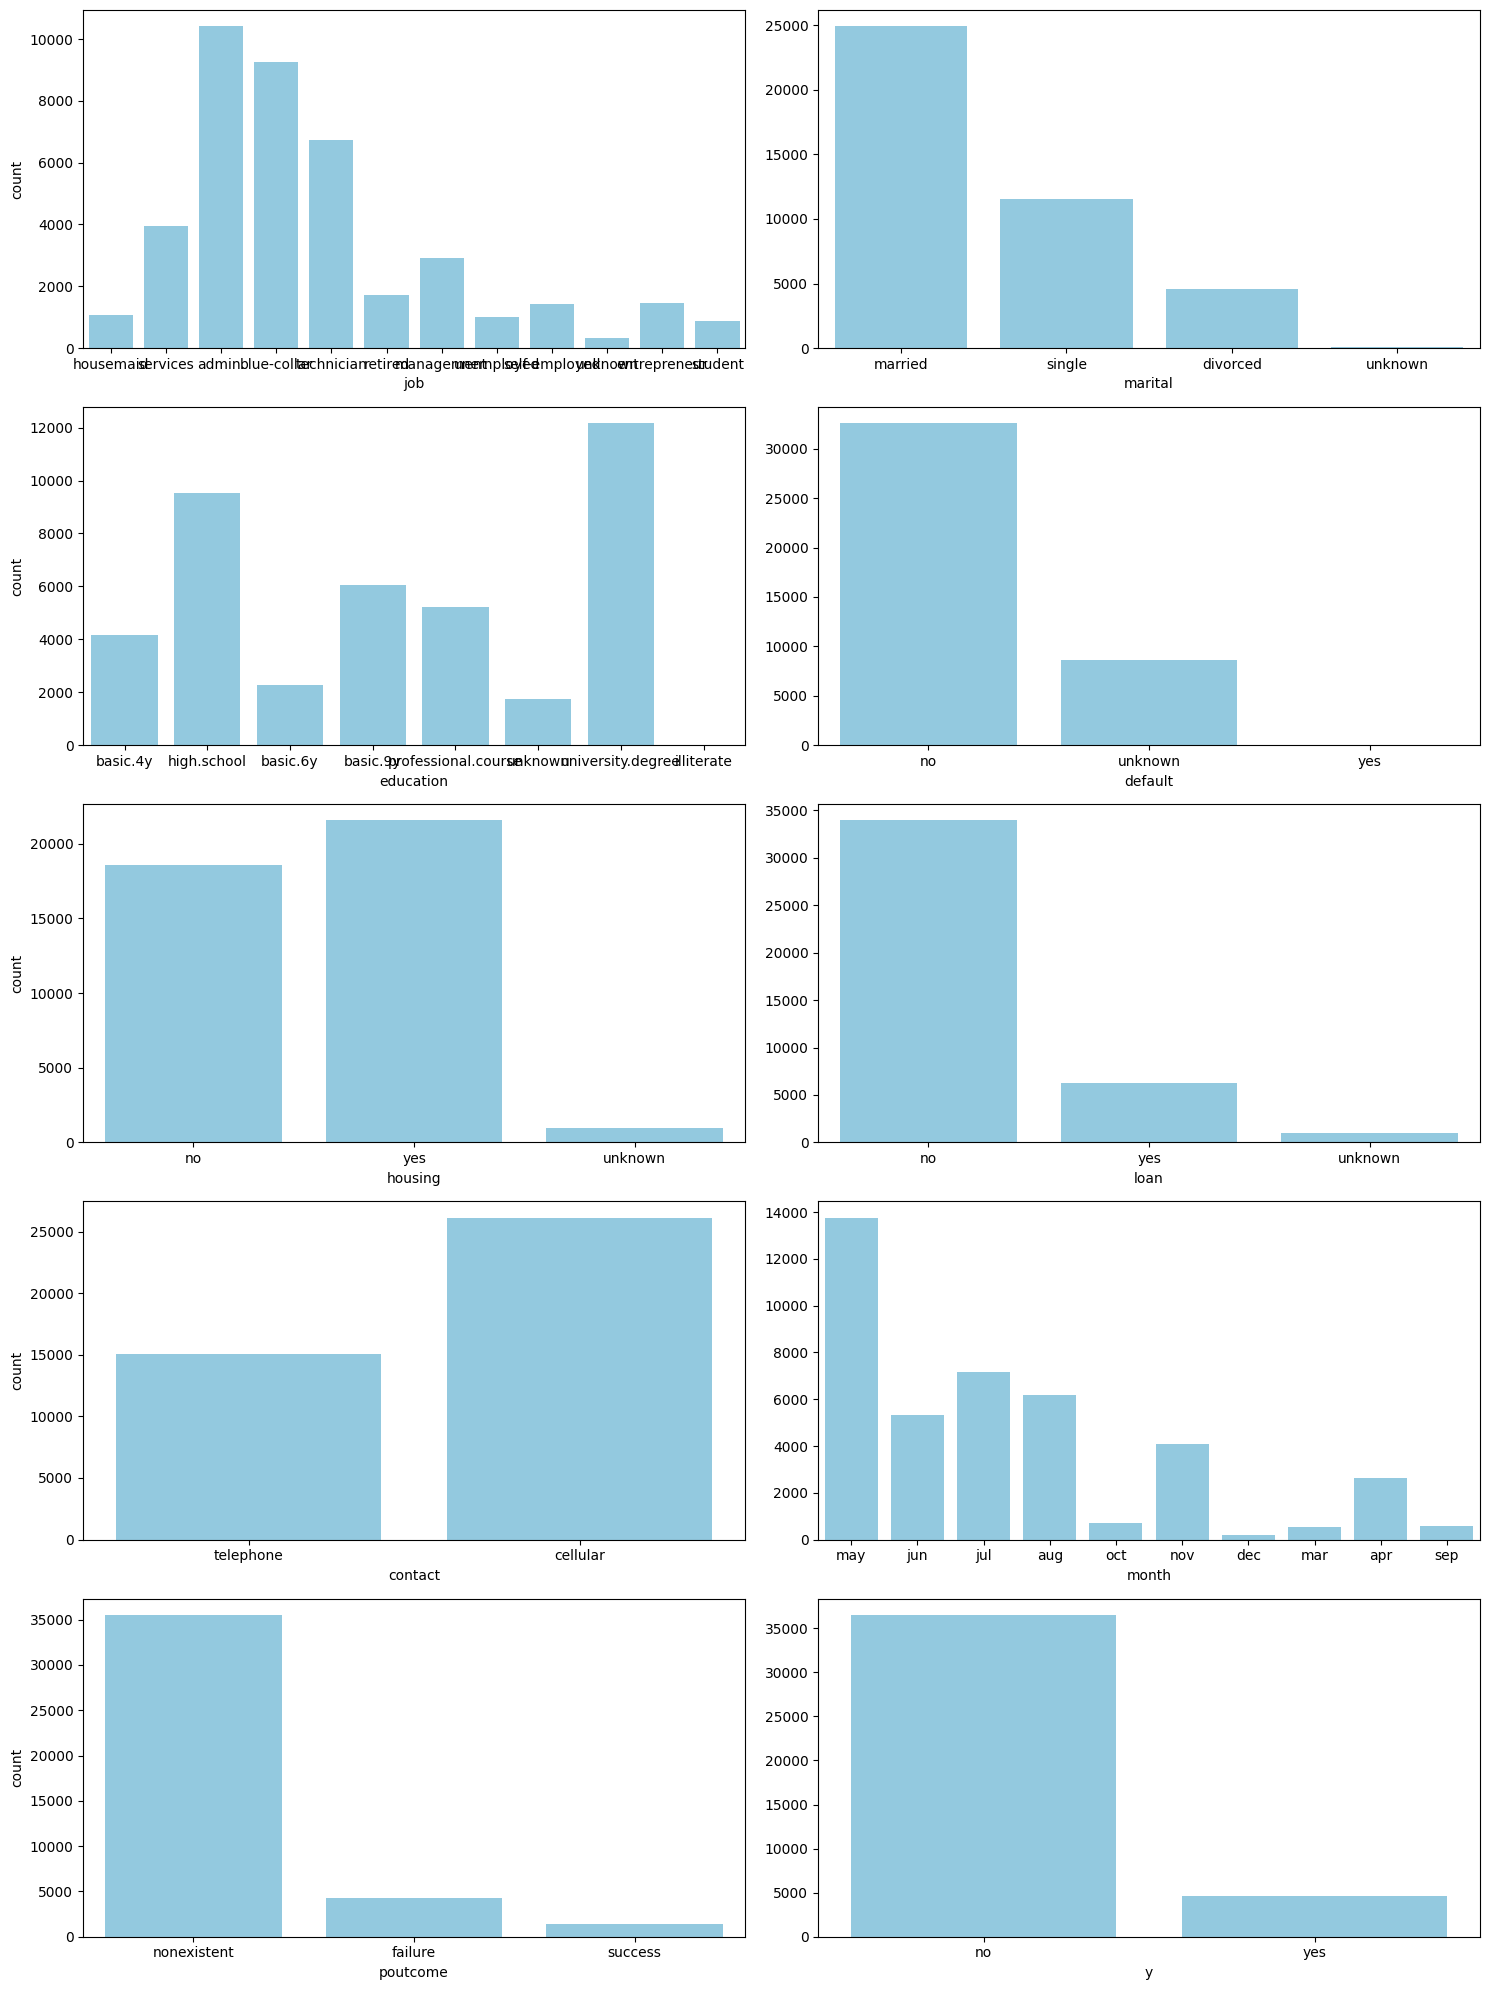

In [74]:
# Creating countplots for the categorical variables
# It is better to use countplot to visualize the behavior 
nrows = 5
ncols = 2
fig, axes = plt.subplots(nrows= nrows, ncols= ncols, figsize = (15, 20))
axes_flat = axes.flatten()

for i, col in enumerate(categorical_val):
    row = i // ncols
    col_pos = i % ncols
    sns.countplot(data = df, x= col,  ax = axes[row, col_pos], orient= 'v', color= "skyblue")
    if col_pos == 1:
        axes[row, col_pos].set(ylabel= None)
    
    
    # Hide any unused subplots
for j in range(i + 1, len(axes_flat)):
    axes_flat[j].set_visible(False)

plt.tight_layout()
plt.show()

### 4.1.1 Conclusions on Countplot for categorical variables
- **The Target (y)**: The "no" bars are massive compared to the "yes" bars. This confirms an imbalance (roughly 90% No vs. 10% Yes).
- **The (default) Column**: Almost every single person is in the "no" or "unknown" category. There are very few "yes" cases. Because there is almost no variation here, this column likely won't help the model predict a "yes" subscription. It’s a strong candidate for deletion.
- **Seasonality (month)**: There is a huge spike in May. This suggests the bank is very active in the spring. We might check if the "yes" rate is higher in smaller months like September or December.
- **Column (poutcome)**: While most are "nonexistent," the "success" category is small but might be powerful. If a customer said yes before, they are highly likely to say yes again.
- **Job & Education**: there are a lot of categories here. For the Logistic Regression, these are the largest groups. they might be to be factorized in order to be able to rank them with numbers.

## 4.2 Numeric Variables Analysis

In [75]:
# Select only columns with 'int or float' data type (numeric
numerics = df.select_dtypes(include= ['number']).columns.tolist()
print(f"Numeric variables: {numerics}")

Numeric variables: ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


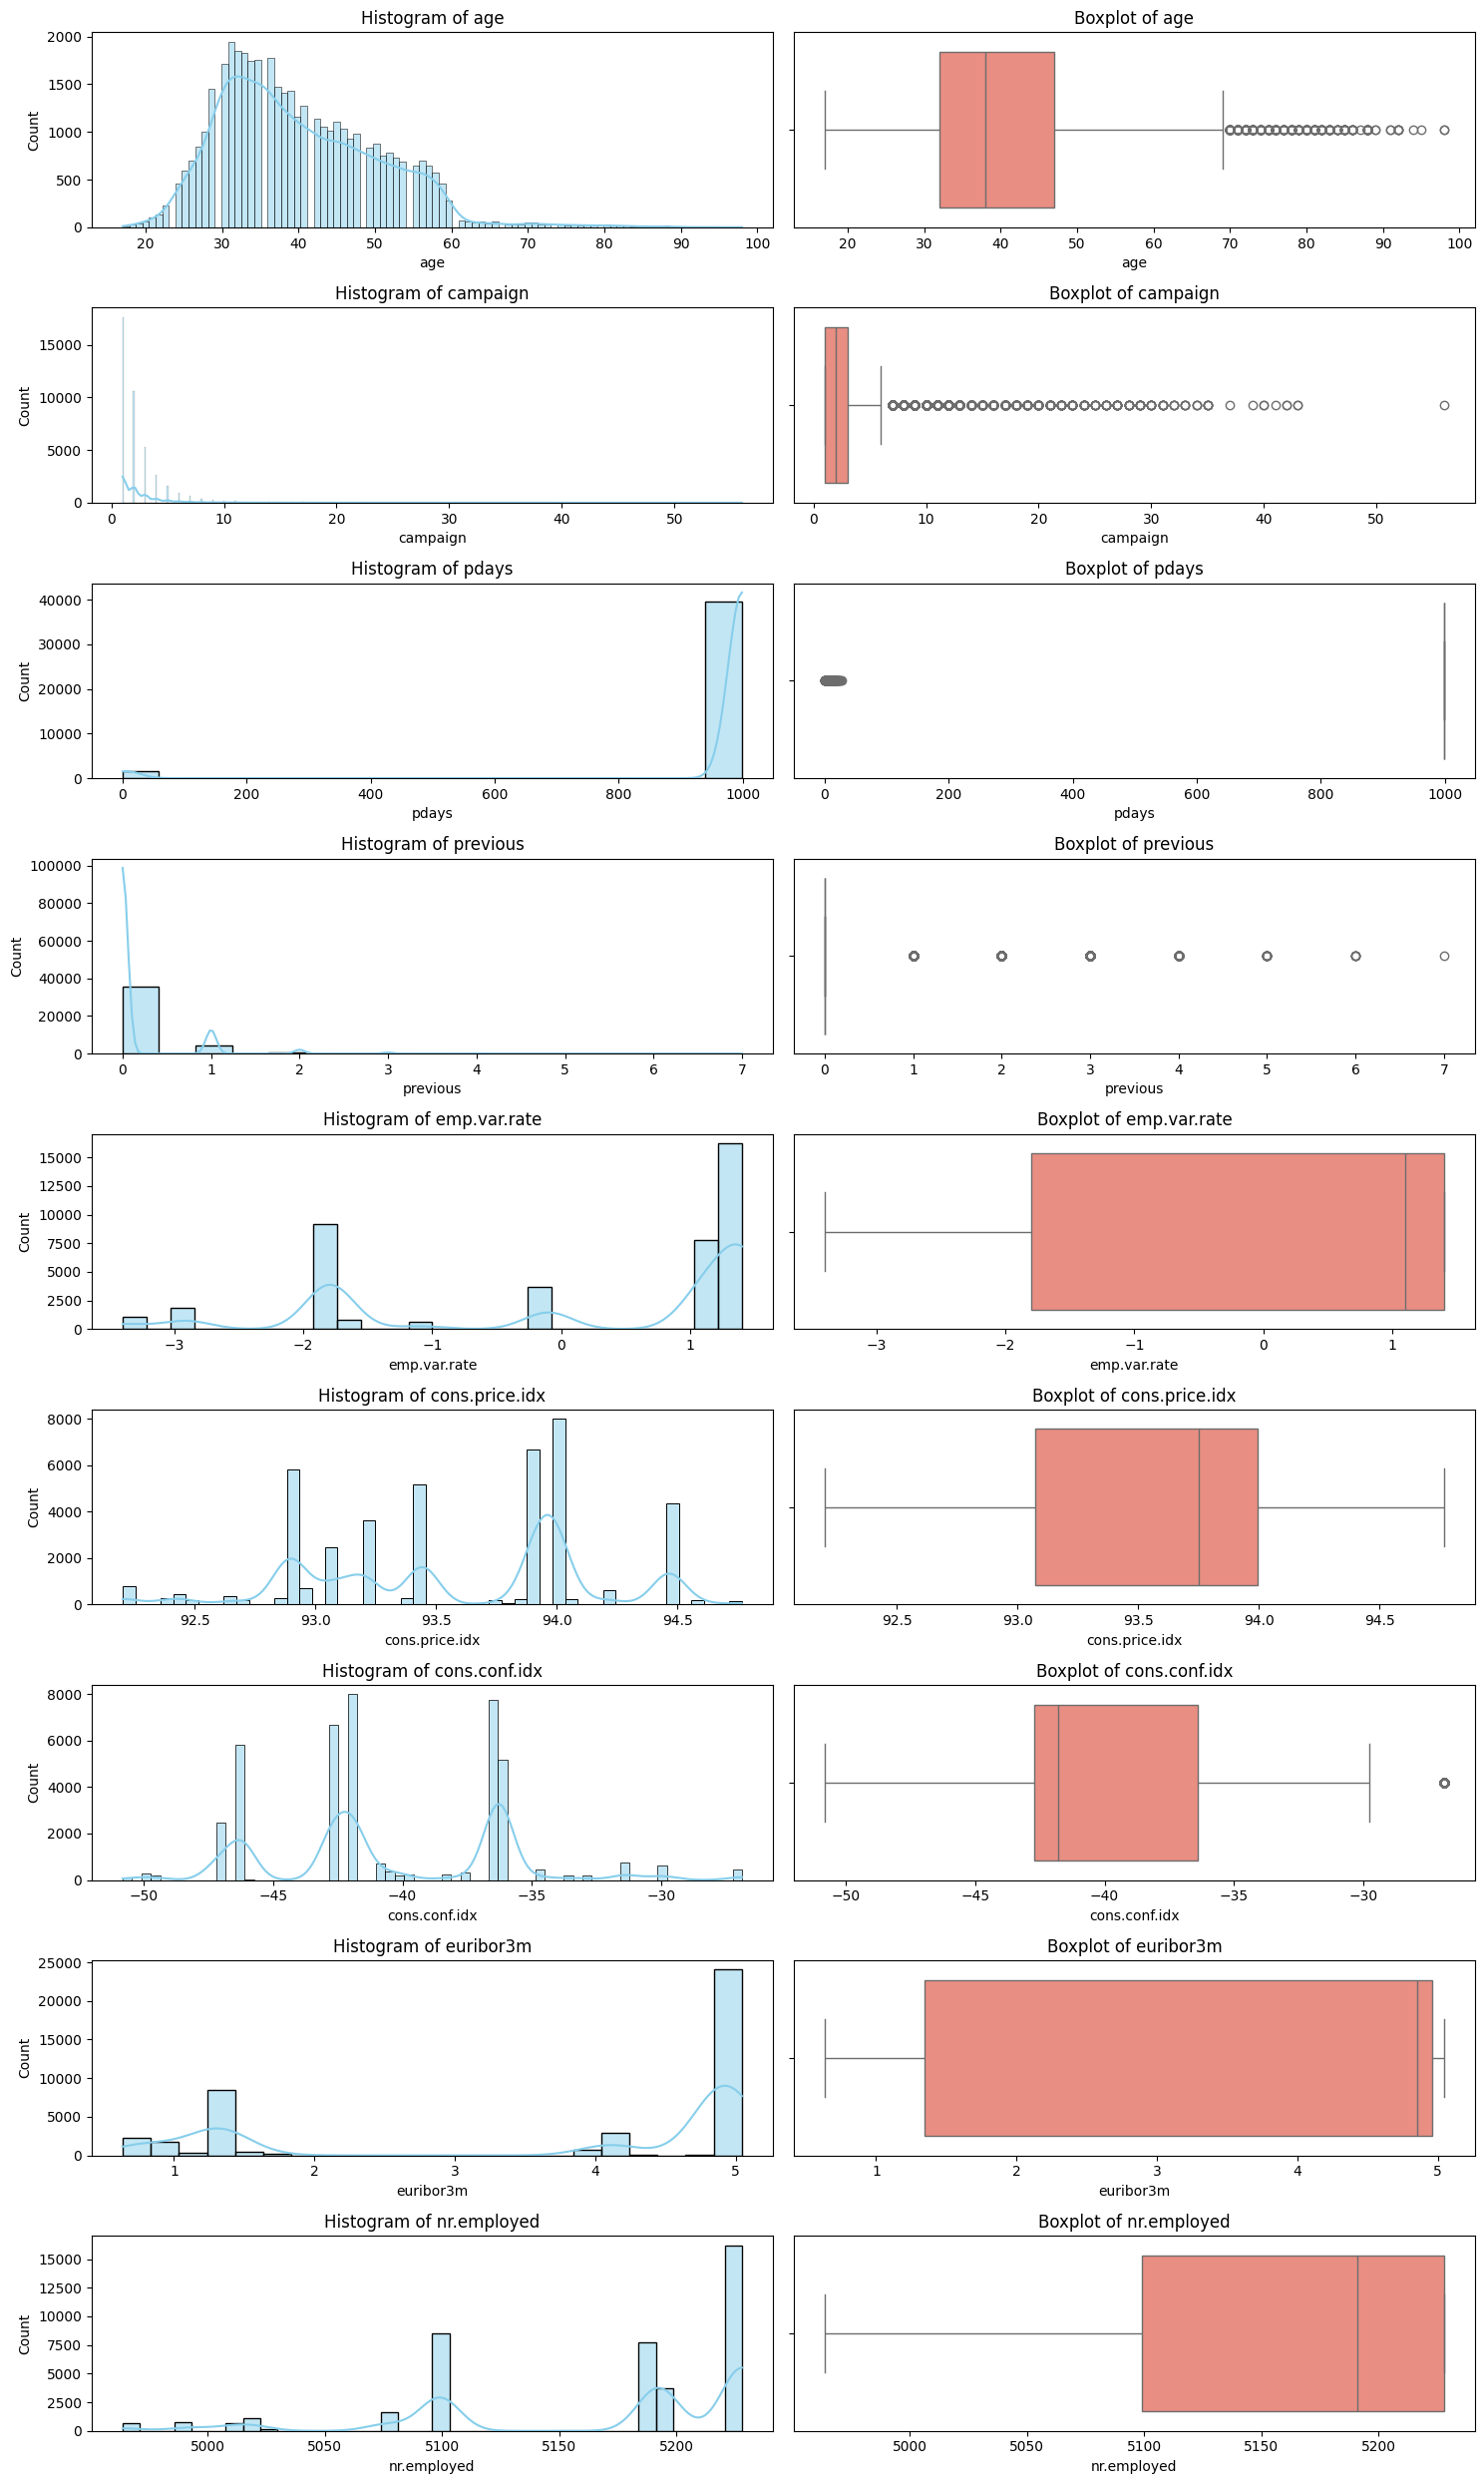

In [76]:
# Creating histplot and boxplot for the numeric variables
fig, axes = plt.subplots(nrows=len(numerics), ncols=2, figsize=(15, 25))

for i, col in enumerate(numerics):
    sns.histplot(df[col], kde=True, ax=axes[i, 0], color="skyblue")
    axes[i, 0].set_title(f'Histogram of {col}')
    
    sns.boxplot(x=df[col], ax=axes[i, 1], color="salmon")
    axes[i, 1].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

### 4.2.1 Conclusions for Numerical Variable Charts
- **age**: It is the most "normal" looking distribution. It’s slightly right-skewed, and the boxplot shows quite a few outliers above age 70. This might suggest bank customers are working-ag.
- **campaign**: This is extremely skewed. Most people are contacted 1–3 times, but the boxplot shows someone was contacted over 50 times.
- **pdays**: This is almost entirely one bar at 999. This confirms that for the vast majority of the data, there was no previous contact.
- **Economic Indicators (emp.var.rate, euribor3m, nr.employed)**: Notice how these look multimodal. They aren't traditional continuous numbers like age.

# Step 5: Multivariate Variables Analysis
## 5.1 Numerical-numerical Analysis

In [77]:
# 1. Define mapping
y_mapping = {'yes': 1, 'no': 0}

# 2. Save to JSON
with open('../data/interim/target_mapping.json', 'w') as f:
    json.dump(y_mapping, f)

# 3. Apply it
df['y_num'] = df['y'].map(y_mapping)
df = df.drop(['y'], axis= 1)
print(tabulate(df.head(), headers= "keys", tablefmt= "psql"))

+----+-------+-----------+-----------+-------------+-----------+-----------+--------+-----------+---------+------------+---------+------------+-------------+----------------+------------------+-----------------+-------------+---------------+---------+
|    |   age | job       | marital   | education   | default   | housing   | loan   | contact   | month   |   campaign |   pdays |   previous | poutcome    |   emp.var.rate |   cons.price.idx |   cons.conf.idx |   euribor3m |   nr.employed |   y_num |
|----+-------+-----------+-----------+-------------+-----------+-----------+--------+-----------+---------+------------+---------+------------+-------------+----------------+------------------+-----------------+-------------+---------------+---------|
|  0 |    56 | housemaid | married   | basic.4y    | no        | no        | no     | telephone | may     |          1 |     999 |          0 | nonexistent |            1.1 |           93.994 |           -36.4 |       4.857 |          5191 |   

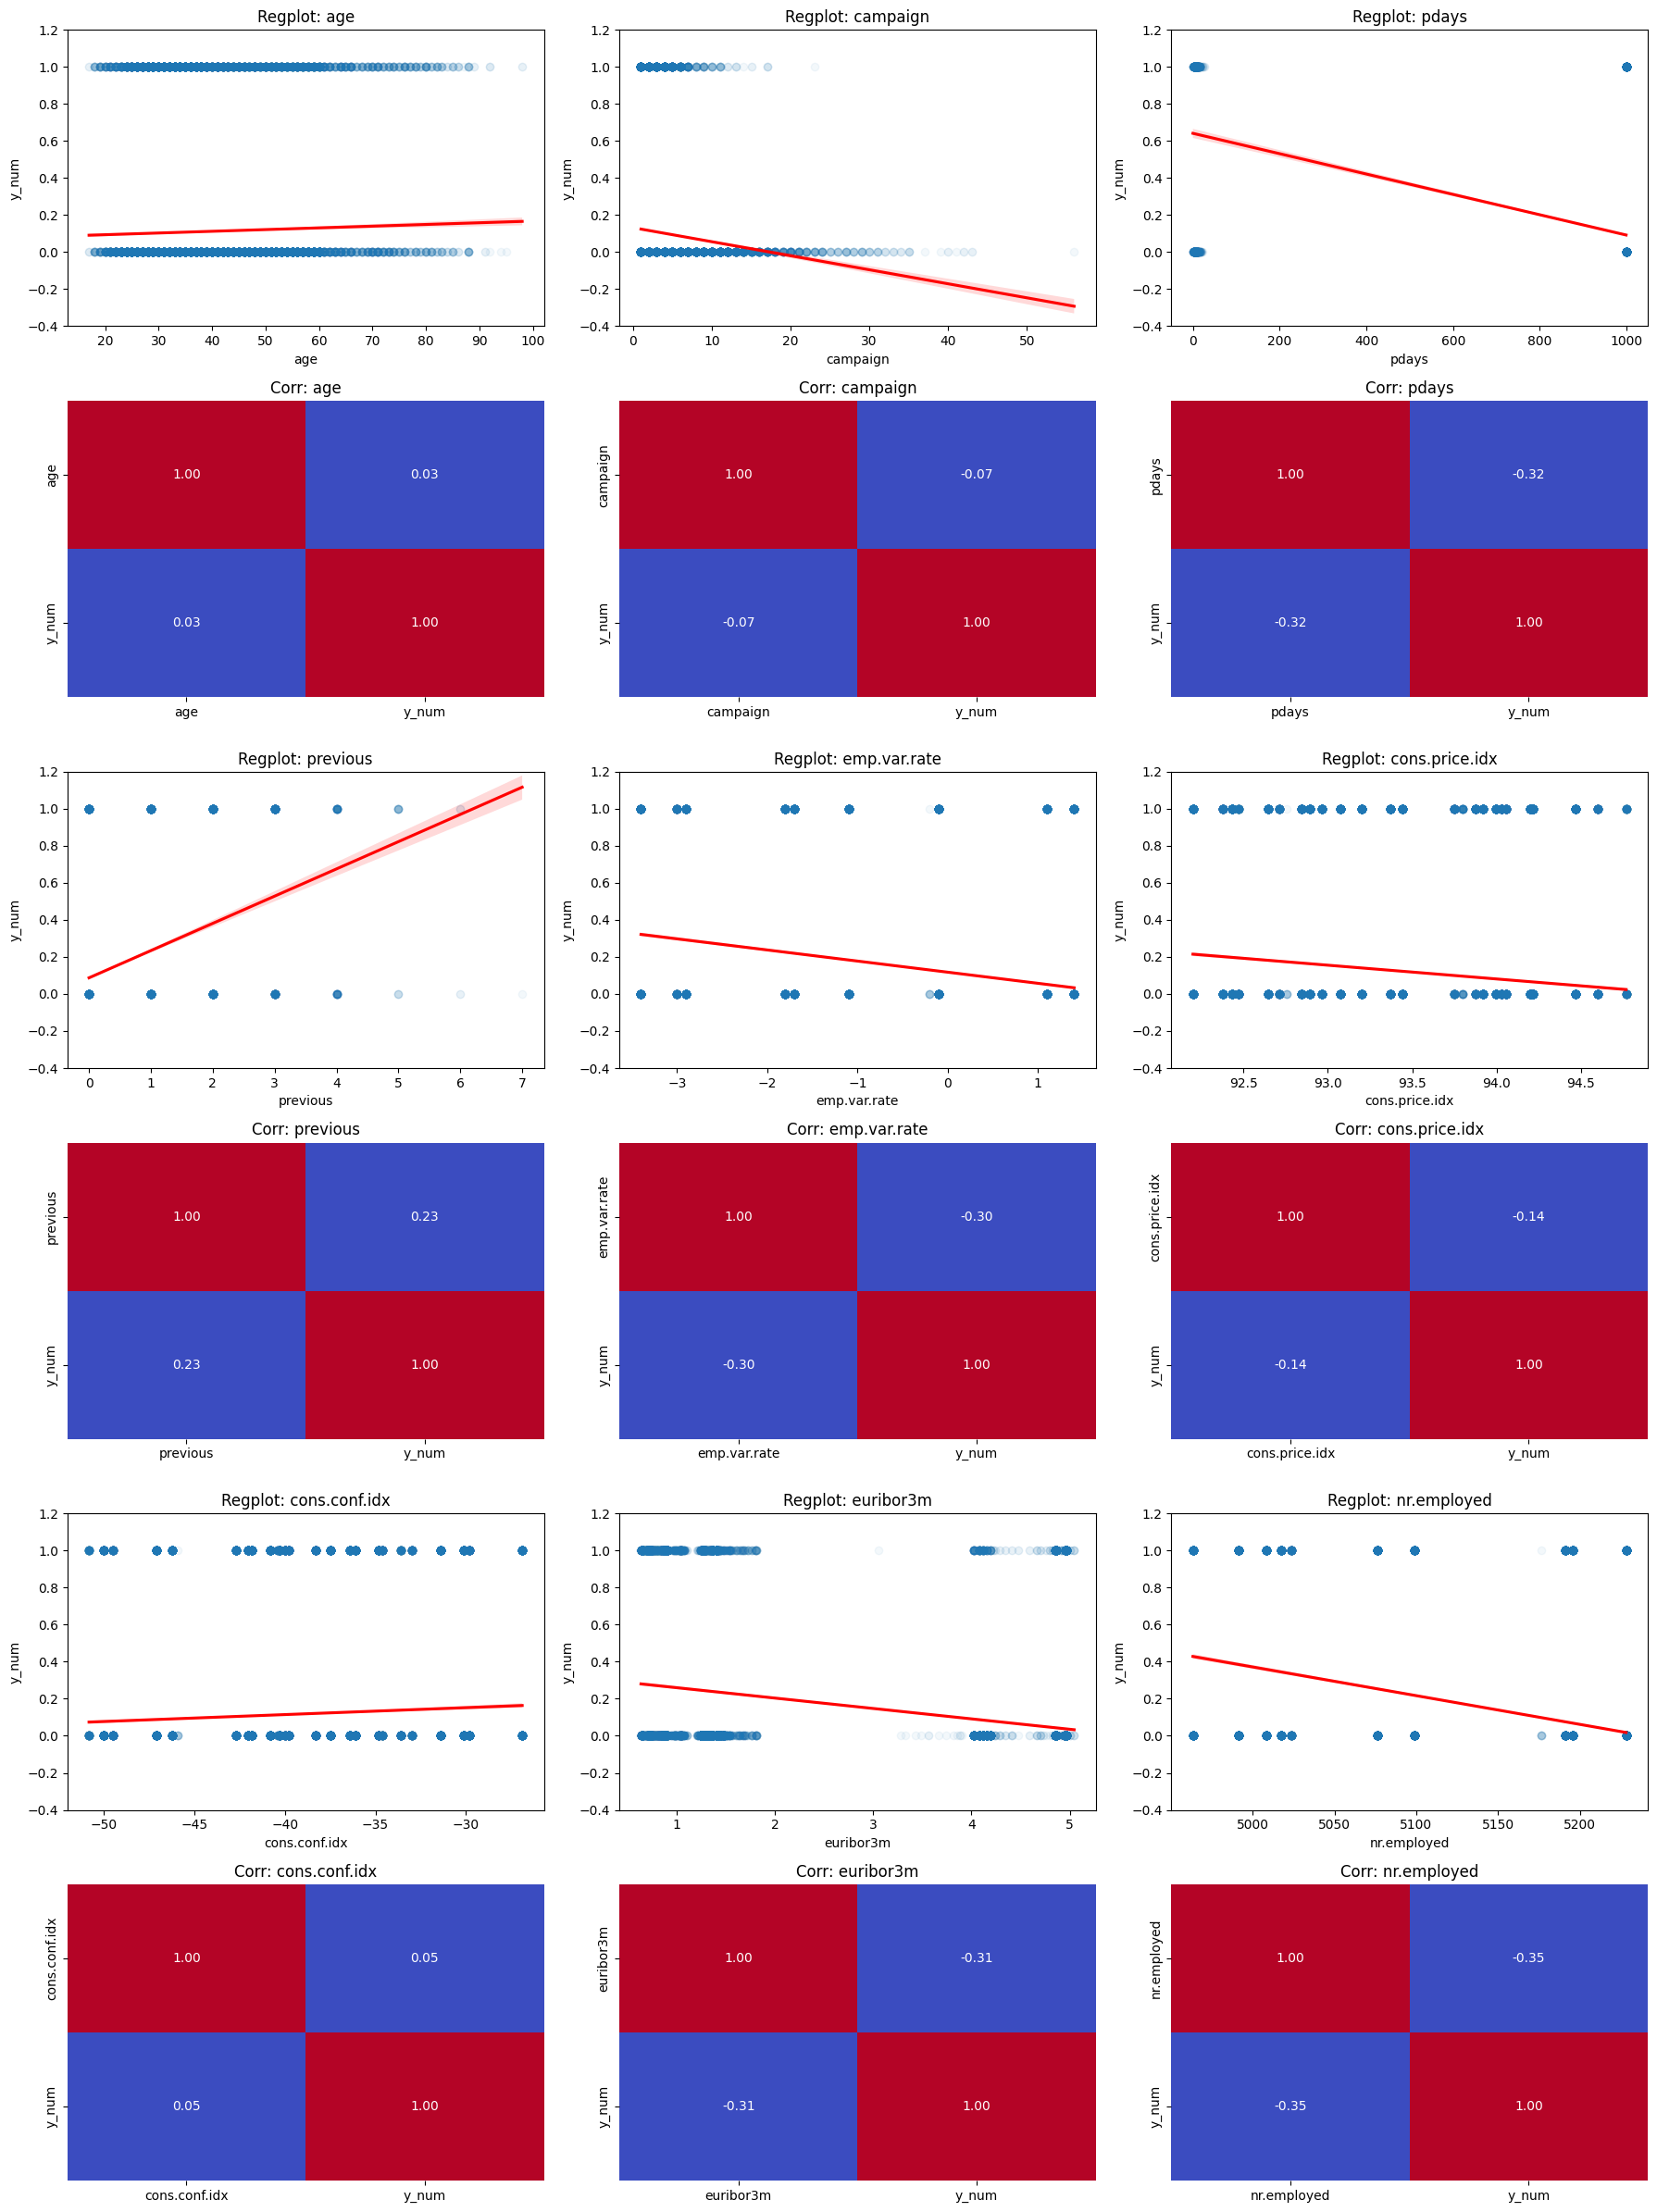

In [78]:
# Numeric variables: ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
# 2. Excluding the target. The condition is to avoid ploting the target with itself.
if 'y_num' in numerics: numerics.remove('y_num')

# 3. Calculate Grid Size
ncols = 3
group_chart = math.ceil(len(numerics) / ncols)
nrows = group_chart * 2 # Double the rows (one for Reg, one for Heatmap)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 4 * nrows))

for chart_idx in range(group_chart):
    # Determine which row we are on for Regplots
    reg_row = chart_idx * 2
    # The Heatmap row is always the one right below it
    heat_row = reg_row + 1

    # Get the 3 variables for this group
    start = chart_idx * ncols
    end = start + ncols
    current_vars = numerics[start:end]

    for col_idx, col in enumerate(current_vars):
        # --- Plot 1: Regplot ---
        sns.regplot(data= df, x= col, y= 'y_num', ax= axes[reg_row, col_idx], scatter_kws={'alpha':0.05}, line_kws={'color':'red'}).set_ylim(-0.4, 1.2)
        axes[reg_row, col_idx].set_title(f'Regplot: {col}')
        # --- Plot 2: Heatmap ---
        sns.heatmap(df[[col, 'y_num']].corr(), annot=True, fmt=".2f", ax=axes[heat_row, col_idx], cbar=False, cmap='coolwarm')
        axes[heat_row, col_idx].set_title(f'Corr: {col}')
# 4. Hide empty slots (if any)
for col_idx in range(len(current_vars), ncols):
    axes[reg_row, col_idx].set_visible(False)
    axes[heat_row, col_idx].set_visible(False)

plt.tight_layout()
plt.show()

### 5.1.1 Conclusion Num-Num analysis
- **nr.employed (-0.35) and euribor3m (-0.31)**: These economic indicators have the strongest negative correlations. This suggests that when interest rates are higher, people are significantly less likely to subscribe.
- **pdays (-0.32)**: This confirms that as the number of days since last contact increases, the chance of a "yes" drops significantly.
- **previous (0.23)**: This has the strongest positive correlation. If the bank has talked to this person before, they are much more likely to say "yes" now.
- **age (0.03) and cons.conf.idx (0.05)**: These lines are almost flat. While age is a good demographic to know, it doesn't strictly dictate whether someone will say yes or no in this specific dataset.
- **campaign (-0.07)**: The negative slope shows the more times you call a customer during a single campaign, the less likely they are to eventually subscribe.

## 5.2 Numerical-numerical Analysis (other predictors)

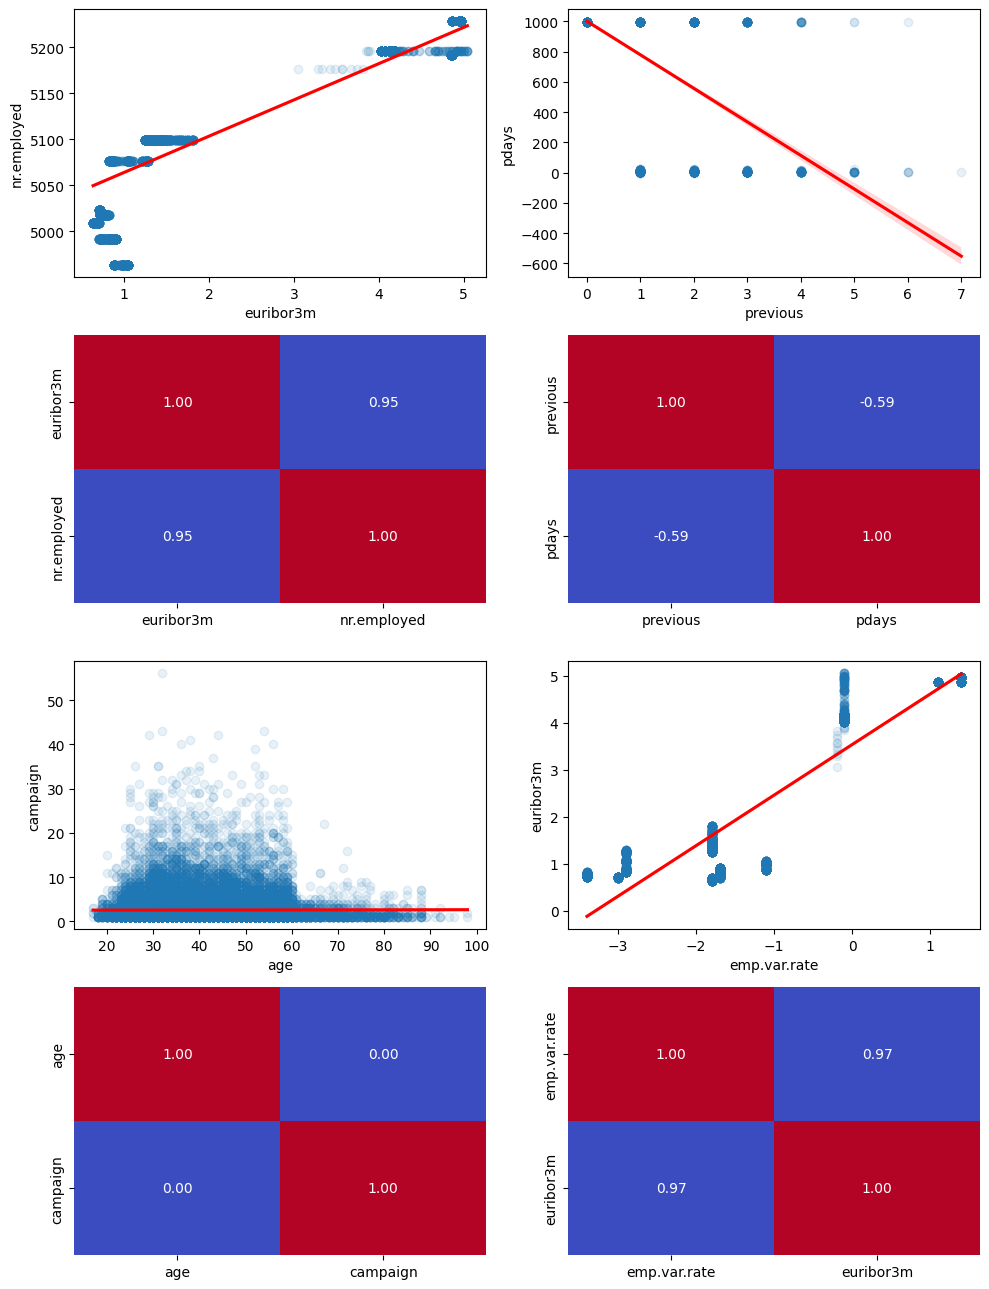

In [79]:
# A quick checking for Multicollinearity between two specific predictors
fig, axes = plt.subplots(nrows= 4, ncols= 2, figsize=(10, 13))

sns.regplot(data=df, ax=axes[0, 0], x='euribor3m', y='nr.employed', scatter_kws={'alpha':0.1}, line_kws={'color':'red'})
sns.heatmap(df[['euribor3m', 'nr.employed']].corr(), annot=True, fmt=".2f", ax=axes[1, 0], cbar=False, cmap='coolwarm')

sns.regplot(data=df, ax=axes[0, 1], x='previous', y='pdays', scatter_kws={'alpha':0.1}, line_kws={'color':'red'})
sns.heatmap(df[['previous', 'pdays']].corr(), annot=True, fmt=".2f", ax=axes[1, 1], cbar=False, cmap='coolwarm')

sns.regplot(data=df, ax=axes[2, 0], x='age', y='campaign', scatter_kws={'alpha':0.1}, line_kws={'color':'red'})
sns.heatmap(df[['age', 'campaign']].corr(), annot=True, fmt=".2f", ax=axes[3, 0], cbar=False, cmap='coolwarm')

sns.regplot(data=df, ax=axes[2, 1], x='emp.var.rate', y='euribor3m', scatter_kws={'alpha':0.1}, line_kws={'color':'red'})
sns.heatmap(df[['emp.var.rate', 'euribor3m']].corr(), annot=True, fmt=".2f", ax=axes[3, 1], cbar=False, cmap='coolwarm')

plt.tight_layout()
plt.show()

### 5.2.1 Conclusion Num-Num (others predictors)
* 1. Confirmed Redundancy (Multicollinearity). The heatmaps prove that variables are nearly identical.
    - Euribor3m vs Nr.Employed: Shows a correlation of 0.95.
    - Emp.Var.Rate vs Euribor3m: Shows a correlation of 0.97.
    - **Conclusion**: For the logistic Regression, I must drop 2 of these and keep only one (typically nr.employed as it usually has the strongest link to the target).
* 2. The Relationship "Floor"
    - Age vs Campaign: The correlation is 0.00.
    - **Conclusion**: There is literally no linear relationship between how old a customer is and how many times they were called.
* 3. Behavioral Inverse Relationship
    - Previous vs Pdays: Shows a correlation of -0.59.
    - **Conclusion**: This negative correlation makes perfect sense—as the number of previous contacts increases, the number of days since the last contact (pdays) tends to decrease.

## 5.5 Categorical-Categorical Analysis

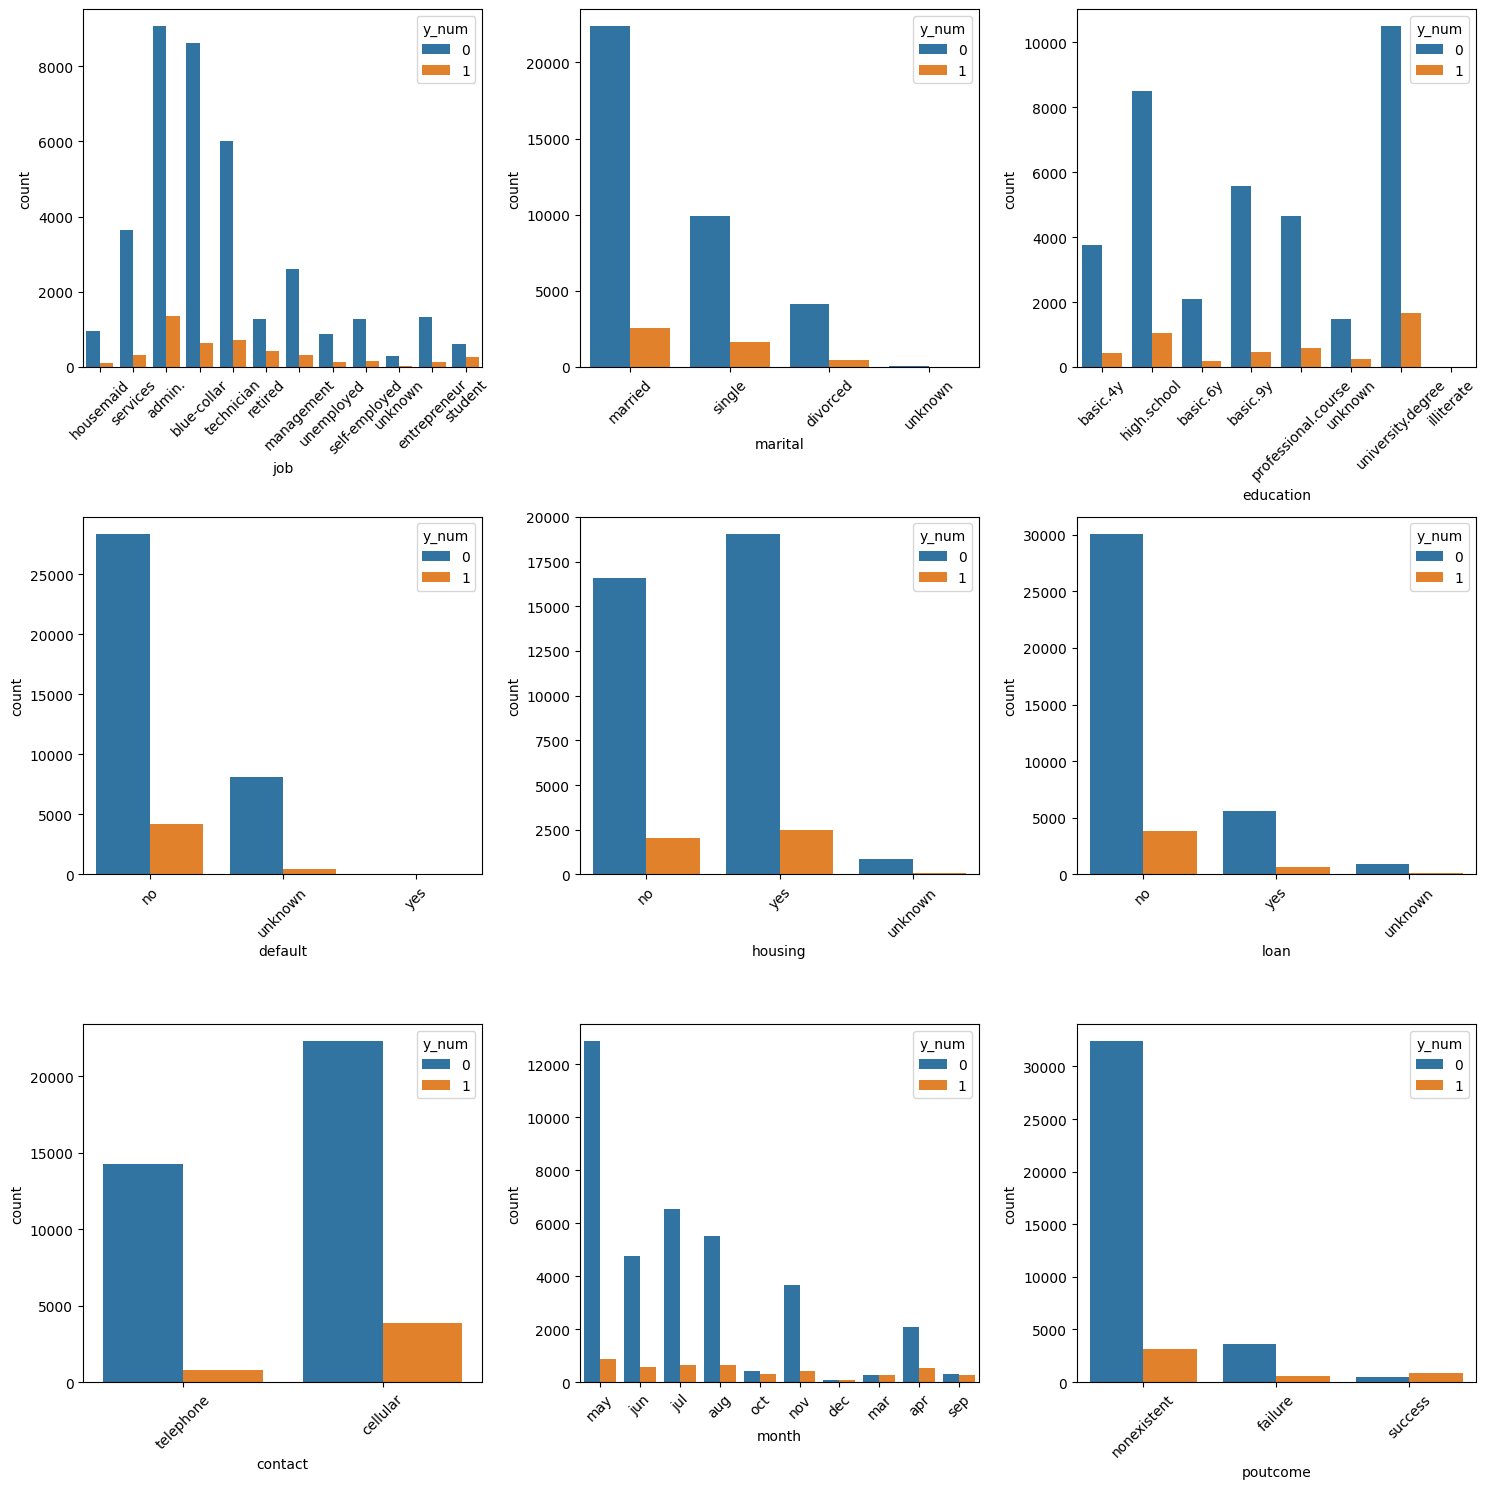

In [80]:
# Categorical Variables: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']
if 'y' in categorical_val: categorical_val.remove('y')
if 'y_num' in categorical_val: categorical_val.remove('y_num')

ncols = 3
nrows = math.ceil(len(categorical_val) / ncols)
fig, axes = plt.subplots(nrows= nrows, ncols= ncols , figsize = (15, 5 * nrows))

axes_flat = axes.flatten()

for i, col in enumerate(categorical_val):
    sns.countplot(ax = axes_flat[i], data = df, x = col, hue = "y_num")
    axes_flat[i].tick_params(axis= 'x', rotation= 45)

for j in range(i + 1, len(axes_flat)):
    axes_flat[j].set_visible(False)

plt.tight_layout()
plt.show()

### 5.5.1 Conclusion Cat - Cat Analysis
* **Potential dropping**:
    - **"default** Notice how the "yes" category is almost invisible. If nearly everyone has the same value, the model can't use this to distinguish between a potential subscriber and a non-subscriber.
    - **loan and housing**: These show very similar ratios of 1s and 0s across all categories. While they are common features, if the ratio of orange (success) to blue (failure) is the same for both "yes" and "no," the variable has low predictive power.
* **Potential Keeping**:
    - **poutcome**: Notice how for previous campaign success, the orange bar is almost the same height as the blue one. This variable is a must-keep.
    - **month**: The conversion rate in(mar), (sep), and (oct) looks much higher than in May.
    - **contact**: People contacted via Cellular have a visibly better success ratio than those on Telephone.
* **The "Noise"**:
    - **marital and education**: While there are slight differences, the ratios are fairly consistent across the main groups. YoI will keep them.

## 5.2 Combinations of poutcome with Others Vredictors

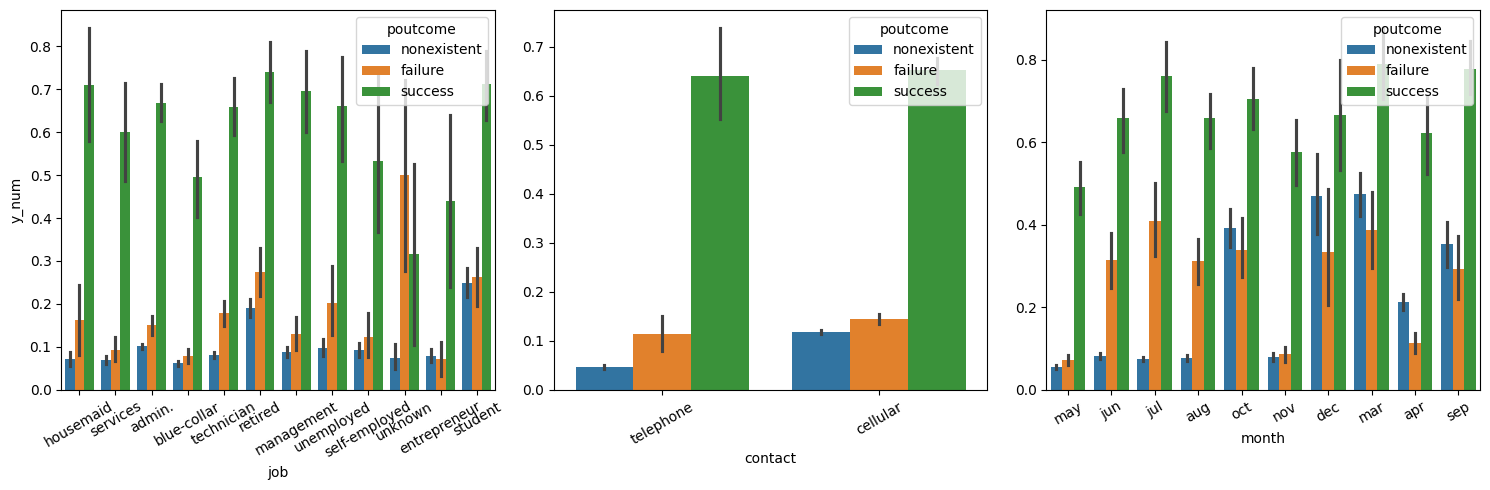

In [81]:
# Creating barplot charts with various predictors
interaction_vars = ['job', 'contact', 'month']
fig, axis = plt.subplots(figsize = (15, 5), ncols = 3)

for i, col in enumerate(interaction_vars):
    sns.barplot(ax = axis[i], data = df, x = col, y = "y_num", hue = "poutcome")
    axis[i].tick_params(axis= 'x', rotation= 30)
    axis[i].legend(title= 'poutcome', loc= 'upper right')
    if i > 0:
        axis[i].set(ylabel= None)

plt.tight_layout()
plt.show()

### 5.2.1 Conclusion poutcome vs.others Predictors
- Across all three charts, the green bar (success) is consistently the tallest. This confirms that a customer's history is the single most important factor.
- Students & Retired: In the job chart, these groups have very high conversion rates when they have a "success" history.
- March, September, October, and December. In these months, the conversion probability for previous "successes" is exceptionally high, often exceeding 70%.

# 5.3 Correlation / Factorize Analysis
In order to seize all variable in a heatmap plot analysis, I will factorize categorical variables and save them in a json.
Categorical variables: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

In [82]:
categorical_vars = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
categorical_num = [var + '_num' for var in categorical_vars]
# Categorical factorization
for col in categorical_num:
    no_num_col = col[:-4]
    df[str(col)] = pd.factorize(df[no_num_col])[0]
# Visibility of the last loop to see factorization
print(tabulate(df[[no_num_col, col]].head(), headers='keys', tablefmt='psql'))

+----+-------------+----------------+
|    | poutcome    |   poutcome_num |
|----+-------------+----------------|
|  0 | nonexistent |              0 |
|  1 | nonexistent |              0 |
|  2 | nonexistent |              0 |
|  3 | nonexistent |              0 |
|  4 | nonexistent |              0 |
+----+-------------+----------------+


## 5.4 Saving the JSON

In [83]:
# Save the json
prefix_name = '_transformation_rules'
for col in categorical_num:
    no_num_col = col[:-4]
    file_name = no_num_col + prefix_name + ".json"
    factorized_dict = {row[no_num_col]: row[col] for index, row in df[[col, no_num_col]].drop_duplicates().iterrows()}
    with open("../data/interim/" + file_name, "w") as f:
        json.dump(factorized_dict, f)

## 5.5 Num - Cat Analysis (Complete)

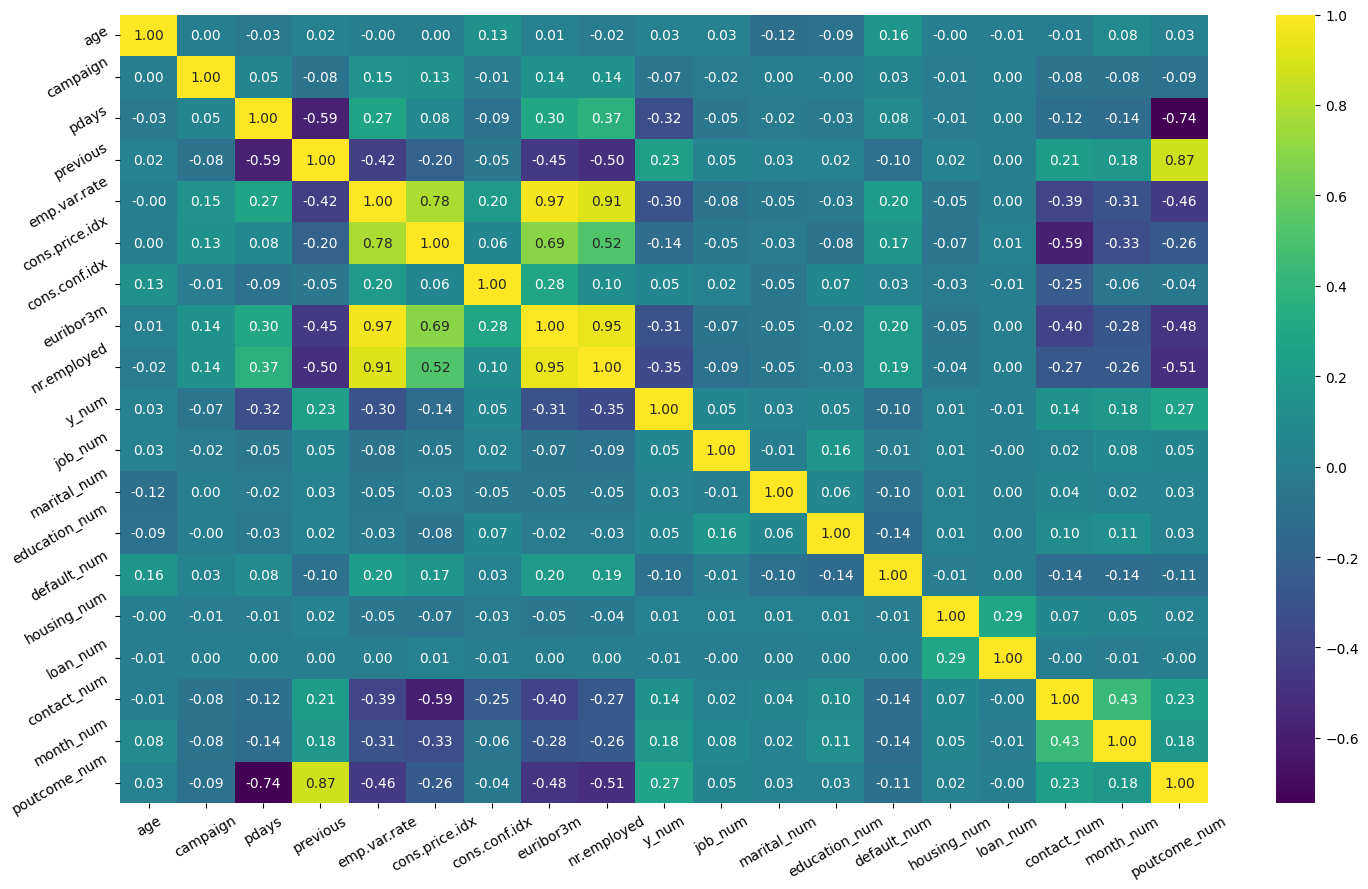

In [84]:
# Creating heatmap chart to analyze complete variables correlation
cols_num = df.select_dtypes(include=['number']).columns.tolist()
fig, ax = plt.subplots(figsize= (15, 9))
sns.heatmap(df[cols_num].corr(method="pearson"), annot=True, fmt=".2f", cmap="viridis", ax= ax).tick_params(rotation= 30)
plt.tight_layout()
plt.show()

### 5.5.1 Conclusion Correlation Heatmap

- **emp.var.rate / euribor3m / nr.employed**: These show extremely high positive correlation (0.91 to 0.97). I'll drop 2 of them keeping **nr.employed** with the strongest individual relationship with the target.
- **poutcome_num & previous**: These have a very strong correlation (0.87). **pdays**: Notice the strong negative correlation with poutcome_num (-0.74) and y_num ($-0.32$).
- **y_num (target)**: Strongest positive: poutcome_num (0.27) and previous $0.23). Strongest negative: pdays (-0.32) and nr.employed (-0.35).
- **housing_num, loan_num, marital_num, and age**: These show nearly $0.00$ correlation with y_num. These are candidates for elimination. They are effectively "random" in relation to whether a customer subscribes, and removing them will simplify the model without losing accuracy.
- **month_num & contact_num**: These show a moderate correlation (0.43), likely because certain marketing campaigns (cellular-heavy) happen in specific months. 
- **cons.price.idx & emp.var.rate**: High correlation (0.78), as inflation and employment rates are naturally linked in the economy.

* Based on this heatmap and previous charts, here is the suggested list:
    - **KEEP** (The Core): poutcome_num, pdays, nr.employed, month_num, contact_num, and job_num.
    - **DROP** (Redundant): emp.var.rate, euribor3m, cons.price.idx, previous.
    - **DROP** (Uninformative): default_num, housing_num, loan_num, age.

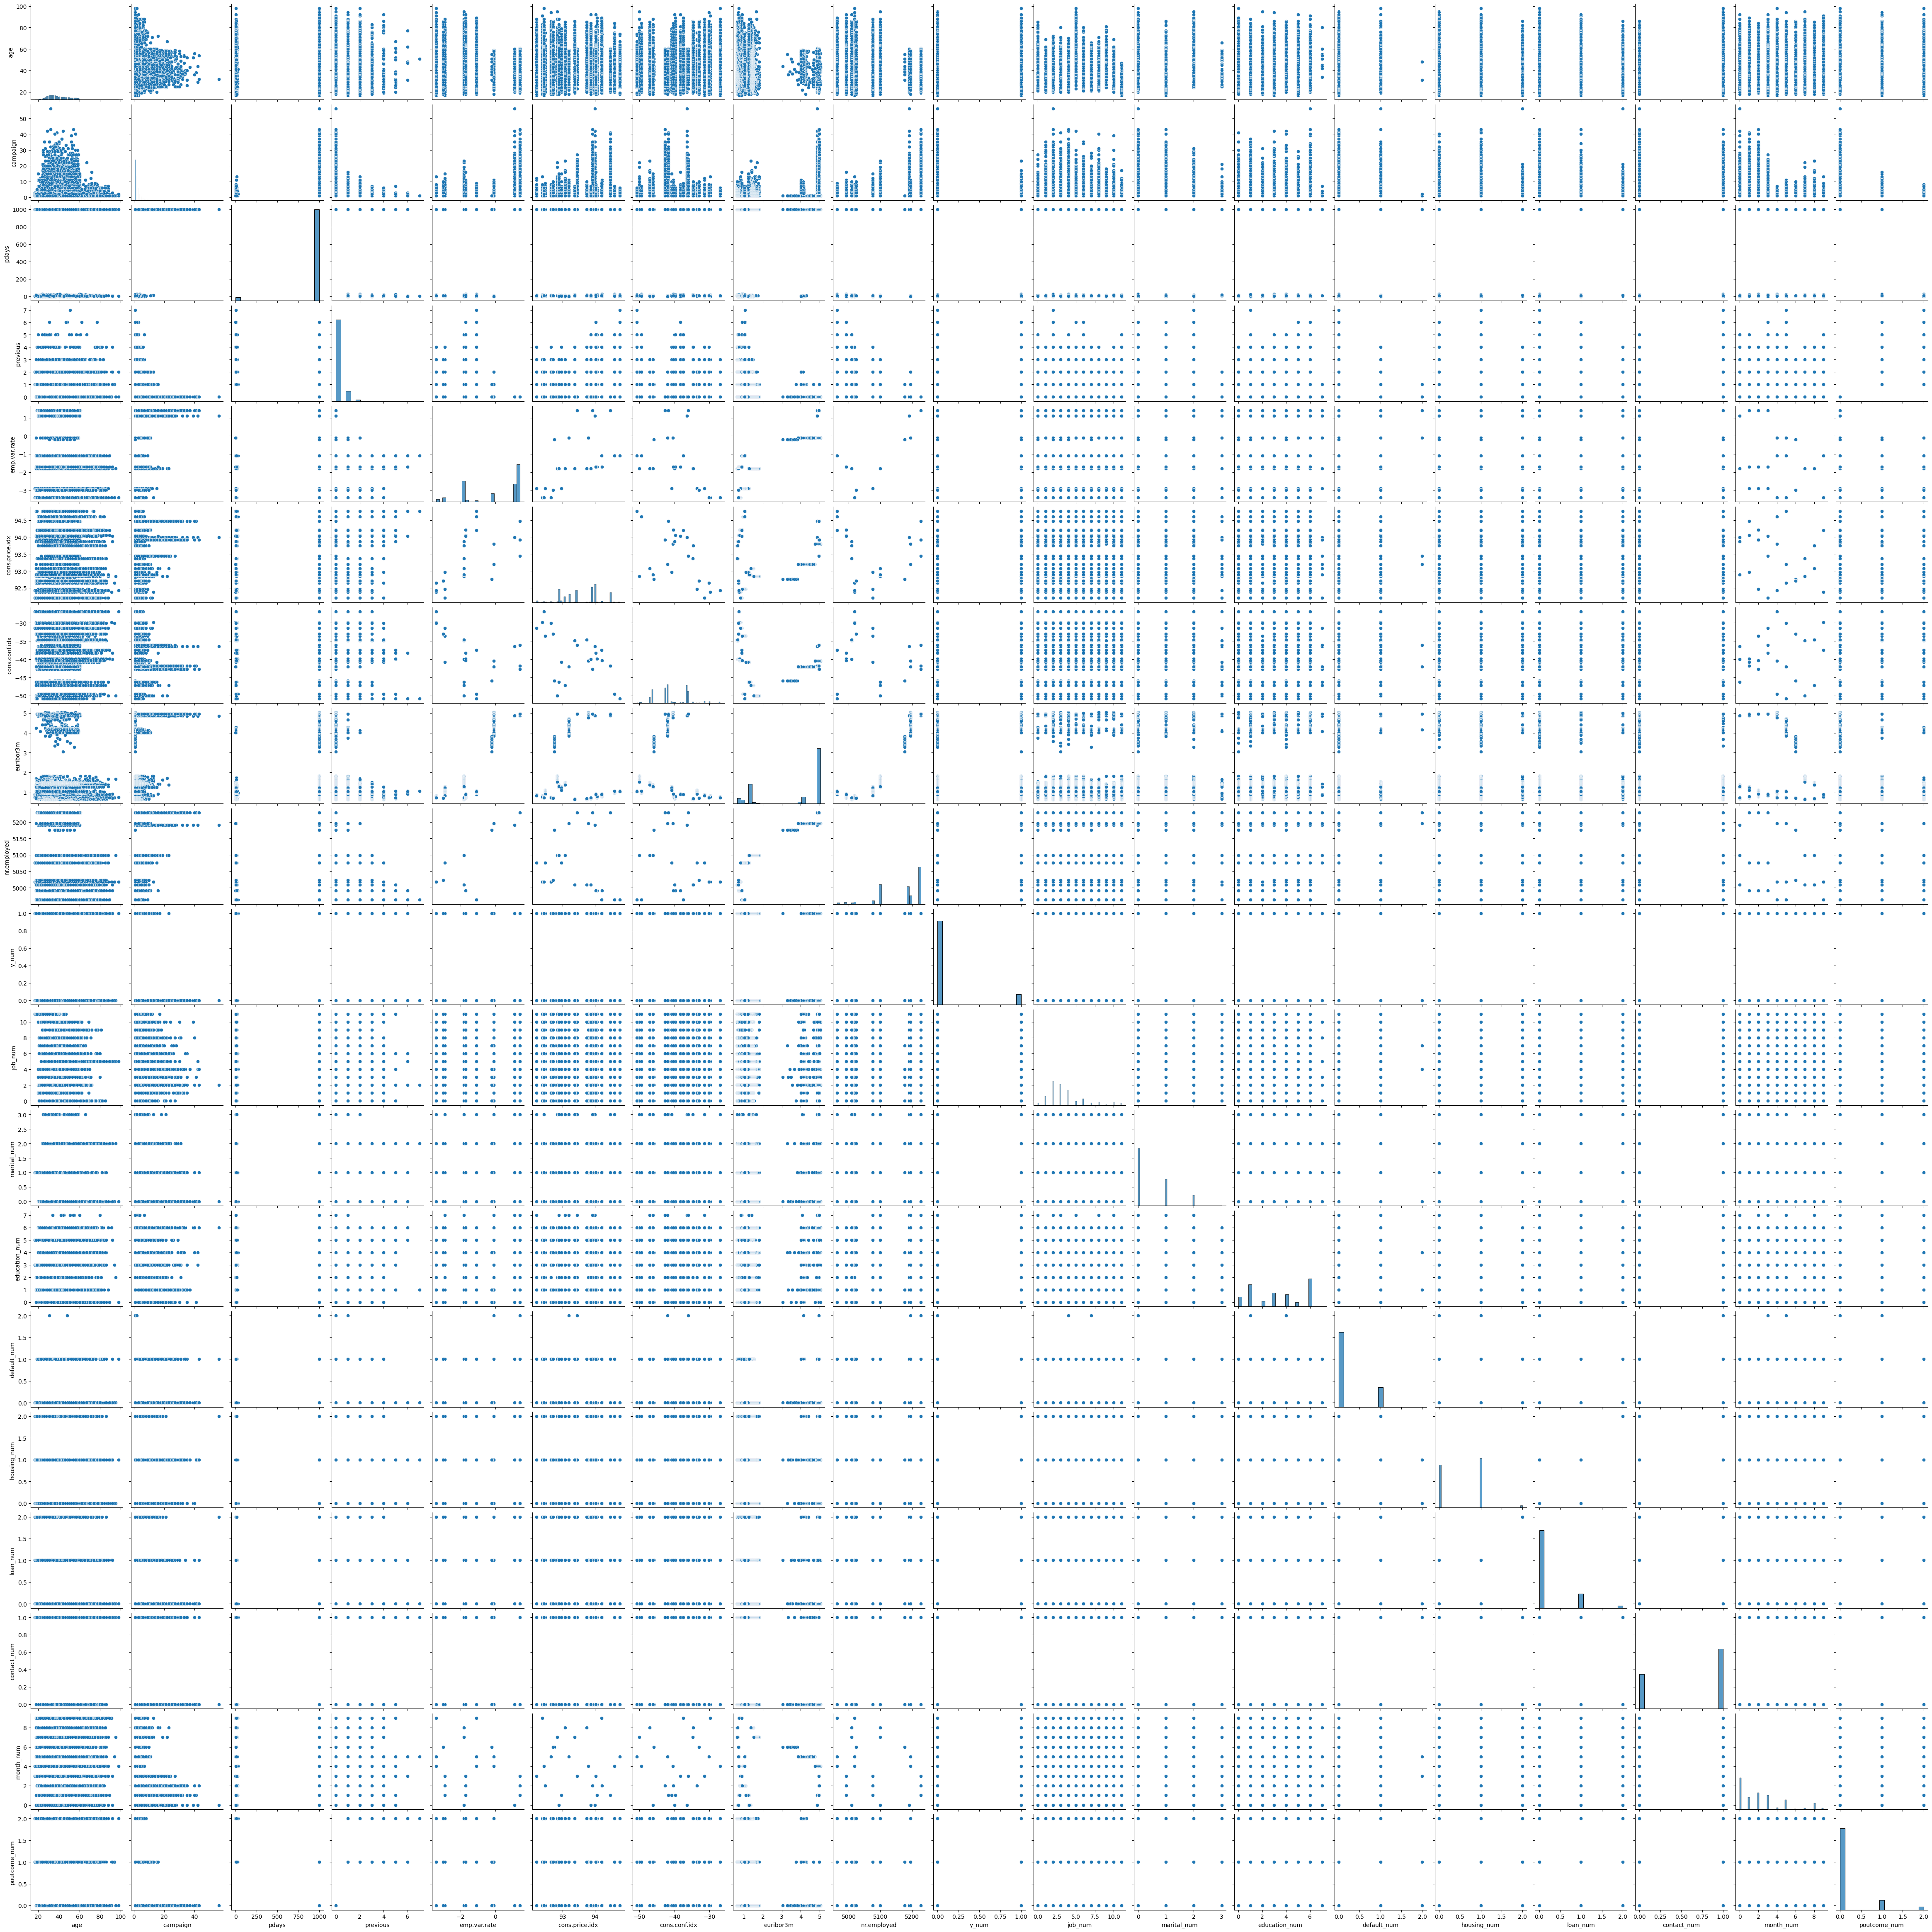

In [85]:
# Creating pairplot to have a variables behaviour visibility 
sns.pairplot(data= df)

## 5.6 Final DataSet Columns
FINAL_COLS = ['campaign', 'pdays', 'cons.conf.idx', 'nr.employed', 'y_num', 'job_num', 'marital_num', 'education_num', 'contact_num', 'month_num', 'poutcome_num']


In [86]:
final_cols = ['campaign', 'pdays', 'cons.conf.idx', 'nr.employed', 'y_num', 'job_num', 'marital_num', 'education_num', 'contact_num', 'month_num', 'poutcome_num']
df = df[final_cols]

In [87]:
print(tabulate(df.describe(), headers= "keys", tablefmt= "psql"))

+-------+-------------+-----------+-----------------+---------------+--------------+-------------+---------------+-----------------+---------------+-------------+----------------+
|       |    campaign |     pdays |   cons.conf.idx |   nr.employed |        y_num |     job_num |   marital_num |   education_num |   contact_num |   month_num |   poutcome_num |
|-------+-------------+-----------+-----------------+---------------+--------------+-------------+---------------+-----------------+---------------+-------------+----------------|
| count | 41176       | 41176     |     41176       |    41176      | 41176        | 41176       |  41176        |     41176       |  41176        | 41176       |   41176        |
| mean  |     2.56788 |   962.465 |       -40.5029  |     5167.03   |     0.112663 |     3.67386 |      0.510637 |         3.27737 |      0.634714 |     2.24995 |       0.169953 |
| std   |     2.77032 |   186.937 |         4.62786 |       72.2514 |     0.316184 |     2.45434 |  

# Step 6: Feature engineering
## 6.1 Outlier analysis

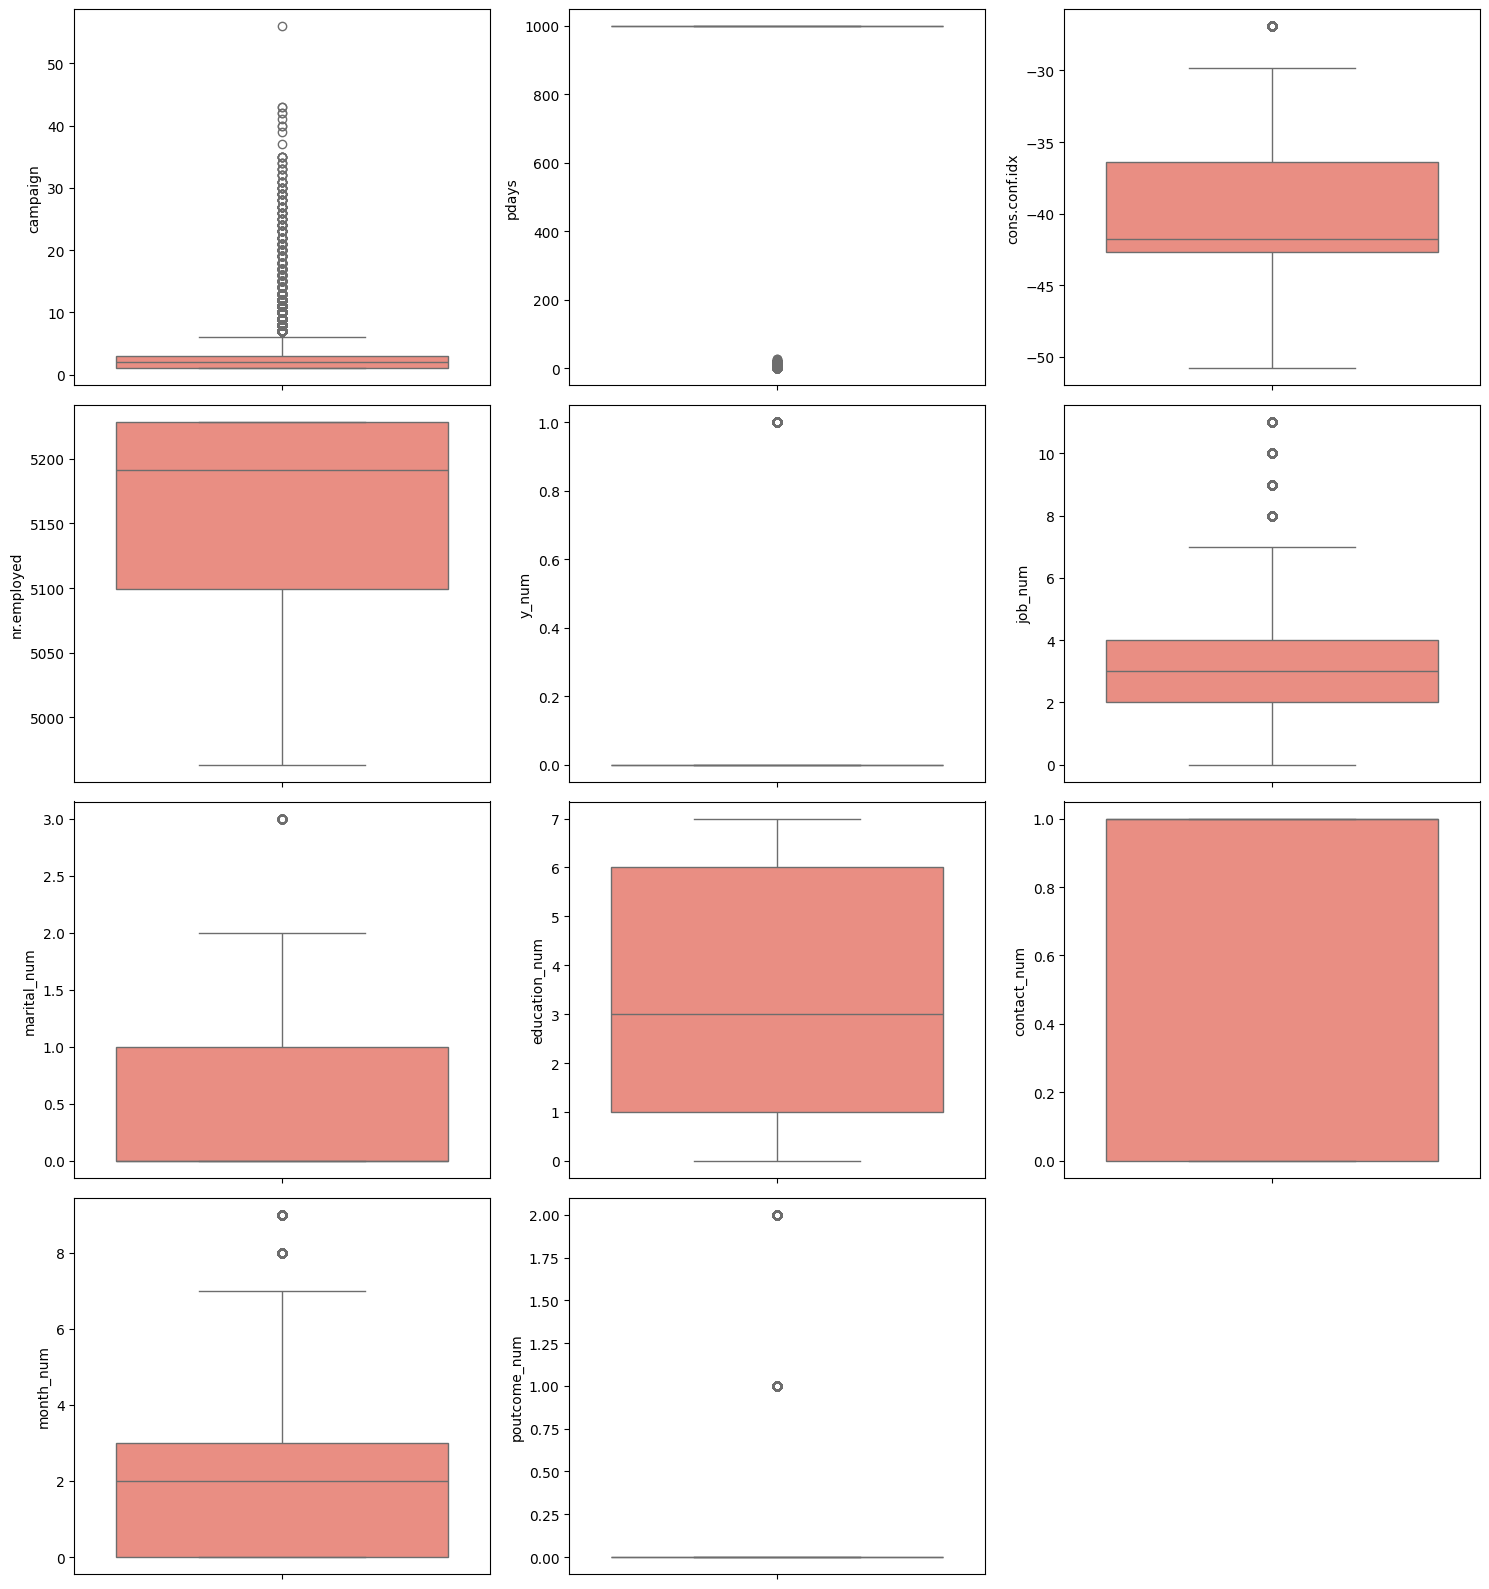

In [88]:
# Creating boxplot to understand the outliers in each variable
ncols = 3
nrows = math.ceil(len(final_cols) / ncols)
fig, axes = plt.subplots(nrows= nrows, ncols= ncols, figsize= (15, 4 * nrows))

axes = axes.flatten()
for i, col in enumerate(final_cols):
    sns.boxplot(data= df, y= col, ax= axes[i], color= 'salmon')
for j in range(len(final_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 6.1.1 Conclusion Boxplots Charts
- **campaign**: Outliers here. Most people are contacted 1–5 times, but some have been contacted over 40 times.
- **pdays**: This chart looks strange because most values are 999. The "outliers" near 0 are actually your most valuable customers. I will not remove these!
- **nr.employed**: No significant outliers here; the data is well-distributed within a normal range.
- **month_num & job_num**: Individual dots at the top. Because these are categorical variables that were factorized into numbers. I'll ignore these as outliers; they are just labels.
- **poutcome_num**: Similar to jobs, the dots at the top represent the "success" category. Since "success" is rare in the dataset, the boxplot treats it as an outlier.
- **cons.conf.idx**: A single outlier at the very top. One specific period had significantly higher consumer confidence than others.

In [89]:
# Necessary coding to replace outliers creating upper and lower limits
# SAVING ALL DATASETS.

df_WITH_outliers = df.copy()
df_WITHOUT_outliers = df.copy() # This need to be modified. For every variable with outliers, I will replce outliers values.

outliers_cols = ['campaign'] # The target variable price can't be modified so we leave as it is.

def replace_outliers(column, data_df):
  col_stats = df[column].describe()
  col_iqr = col_stats["75%"] - col_stats["25%"]
  upper_limit = round(float(col_stats["75%"] + 1.5 * col_iqr), 2)
  lower_limit = round(float(col_stats["25%"] - 1.5 * col_iqr), 2)

  if lower_limit < 0: lower_limit = min(df[column])
  # Let's take out upper outliers 
  data_df[column] = data_df[column].apply(lambda x: x if (x <= upper_limit) else upper_limit)
  # Let's take out lower outliers 
  data_df[column] = data_df[column].apply(lambda x: x if (x >= lower_limit) else lower_limit)
  return data_df.copy(), [lower_limit, upper_limit]

outliers_dict = {}
for column in outliers_cols:
  df_WITHOUT_outliers, limits = replace_outliers(column, df_WITHOUT_outliers)
  outliers_dict.update({column: limits})

outliers_dict # This jason needs to be saved

{'campaign': [1, 6.0]}

In [90]:
# Saving the json dictionary for outliers limit
with open('../data/interim/outliers_dict.json', 'w') as f:
    json.dump(outliers_dict, f)

## 6.2 Missing Value Analysis

In [91]:
print("The list below, will show if dataset WITH outliers has any null value for the variables:")
print(df_WITH_outliers.isnull().sum().sort_values(ascending= False))

The list below, will show if dataset WITH outliers has any null value for the variables:
campaign         0
pdays            0
cons.conf.idx    0
nr.employed      0
y_num            0
job_num          0
marital_num      0
education_num    0
contact_num      0
month_num        0
poutcome_num     0
dtype: int64


In [92]:
print("The list below, will show if dataset WITHOUT outliers has any null value for the variables:")
print(df_WITHOUT_outliers.isnull().sum().sort_values(ascending= False))

The list below, will show if dataset WITHOUT outliers has any null value for the variables:
campaign         0
pdays            0
cons.conf.idx    0
nr.employed      0
y_num            0
job_num          0
marital_num      0
education_num    0
contact_num      0
month_num        0
poutcome_num     0
dtype: int64


## 6.3 Inference of New Features
The pdays variable is messy because of the 999 values. While not removing the outliers, I can simplify the logic for the model. It seems as if 999 represents a hugh number of time a customer have been contacted, and error data or simply just to affirm that it was never contacted before.
I think this 999 is not a real value and will affect my model to really predict the target.
I will drop pdays and will feature this variable and "0" was not contacted and "1" was contacted.

In [93]:
# This gives the raw number of rows where pdays is 999
count_999 = (df['pdays'] == 999).sum()
print(f"Number of 'never contacted' rows: {count_999}")

Number of 'never contacted' rows: 39661


In [94]:
proportion = df['pdays'].value_counts(normalize= True)[999]
print(f"The proportion value of 999 pdays is: {proportion}")

The proportion value of 999 pdays is: 0.9632067223625412


In [95]:
df_WITH_outliers['was_contacted'] = (df_WITH_outliers['pdays'] != 999).astype(int)
df_WITHOUT_outliers['was_contacted'] = (df_WITHOUT_outliers['pdays'] != 999).astype(int)

In [96]:
print("Table with new column was_contacted.\nWITH outliers:")
print(tabulate(df_WITH_outliers.head(), headers= "keys", tablefmt= "psql"))

Table with new column was_contacted.
WITH outliers:
+----+------------+---------+-----------------+---------------+---------+-----------+---------------+-----------------+---------------+-------------+----------------+-----------------+
|    |   campaign |   pdays |   cons.conf.idx |   nr.employed |   y_num |   job_num |   marital_num |   education_num |   contact_num |   month_num |   poutcome_num |   was_contacted |
|----+------------+---------+-----------------+---------------+---------+-----------+---------------+-----------------+---------------+-------------+----------------+-----------------|
|  0 |          1 |     999 |           -36.4 |          5191 |       0 |         0 |             0 |               0 |             0 |           0 |              0 |               0 |
|  1 |          1 |     999 |           -36.4 |          5191 |       0 |         1 |             0 |               1 |             0 |           0 |              0 |               0 |
|  2 |          1 |    

## 6.4 Feature scaling

In [97]:
# Divide the set into train and test

# df_WITH_outliers 
# df_WITHOUT_outliers 
				
predictors = ["campaign", "cons.conf.idx", "nr.employed", "job_num", "marital_num", "education_num", "contact_num", "month_num", "poutcome_num", "was_contacted"]
target = "y_num"

X_WITH_outliers = df_WITH_outliers.drop(target, axis = 1)[predictors]
X_WITHOUT_outliers = df_WITHOUT_outliers.drop(target, axis = 1)[predictors]
y = df_WITH_outliers[target]

X_train_WITH_outliers, X_test_WITH_outliers, y_train, y_test = train_test_split(X_WITH_outliers, y, test_size = 0.2, random_state = 10)
X_train_WITHOUT_outliers, X_test_WITHOUT_outliers = train_test_split(X_WITHOUT_outliers, test_size = 0.2, random_state = 10)

In [98]:
# Normalization and MIN_MAX Scaling

# X_train_WITH_outliers
# X_train_WITHOUT_outliers

# X_test_WITH_outliers
# X_test_WITHOUT_outliers

# WE NEED TO SAVE 3 OCCURRENCE: 1) DATASET PLANE (WITH NO CHANGES), 2) DATASET NORMALIZED, 3) DATASET MIN-MAX

## NORMALIZATION
### WITH OUTLIERS
norm_WITH_outliers = StandardScaler() # StandardScaler(), used to "normalize" or "resize" your data so that all your features are on the same scale. 
# .fit(), The "Learning"
norm_WITH_outliers.fit(X_train_WITH_outliers) # Phase. the scaler (or model) looks at your data and calculates the necessary parameters. It does not change the data; it only learns from it.

# .transform(), The "Applying" Phase.
# NOTE: .fit_transform() — The "Shortcut" --> This is simply a convenience method that does both steps at the same time on the same piece of data. --- Use this on your Training Data ---
X_train_WITH_outliers_norm = norm_WITH_outliers.transform(X_train_WITH_outliers) # This uses the parameters calculated during .fit() to actually modify the data.
X_train_WITH_outliers_norm = pd.DataFrame(X_train_WITH_outliers_norm, index = X_train_WITH_outliers.index, columns = predictors) # We need to convert to DataFrame the transform with this variable

X_test_WITH_outliers_norm = norm_WITH_outliers.transform(X_test_WITH_outliers)
X_test_WITH_outliers_norm = pd.DataFrame(X_test_WITH_outliers_norm, index = X_test_WITH_outliers.index, columns = predictors)

### WITHOUT OUTLIERS
norm_WITHOUT_outliers = StandardScaler()
norm_WITHOUT_outliers.fit(X_train_WITHOUT_outliers)

X_train_WITHOUT_outliers_norm = norm_WITHOUT_outliers.transform(X_train_WITHOUT_outliers)
X_train_WITHOUT_outliers_norm = pd.DataFrame(X_train_WITHOUT_outliers_norm, index = X_train_WITHOUT_outliers.index, columns = predictors)

X_test_WITHOUT_outliers_norm = norm_WITHOUT_outliers.transform(X_test_WITHOUT_outliers)
X_test_WITHOUT_outliers_norm = pd.DataFrame(X_test_WITHOUT_outliers_norm, index = X_test_WITHOUT_outliers.index, columns = predictors)


## SCALED MIN_MAX
### WITH OUTLIERS
scaler_WITH_outliers = MinMaxScaler() # MinMaxScaler is a scaling technique that transforms the data so that all values fall within a specific range, most commonly between 0 and 1.
scaler_WITH_outliers.fit(X_train_WITH_outliers)

X_train_WITH_outliers_scal = scaler_WITH_outliers.transform(X_train_WITH_outliers)
X_train_WITH_outliers_scal = pd.DataFrame(X_train_WITH_outliers_scal, index = X_train_WITH_outliers.index, columns = predictors)

X_test_WITH_outliers_scal = scaler_WITH_outliers.transform(X_test_WITH_outliers)
X_test_WITH_outliers_scal = pd.DataFrame(X_test_WITH_outliers_scal, index = X_test_WITH_outliers.index, columns = predictors)

### WITHOUT OUTLIERS
scaler_WITHOUT_outliers = MinMaxScaler()
scaler_WITHOUT_outliers.fit(X_train_WITHOUT_outliers)

X_train_WITHOUT_outliers_scal = scaler_WITHOUT_outliers.transform(X_train_WITHOUT_outliers)
X_train_WITHOUT_outliers_scal = pd.DataFrame(X_train_WITHOUT_outliers_scal, index = X_train_WITHOUT_outliers.index, columns = predictors)

X_test_WITHOUT_outliers_scal = scaler_WITHOUT_outliers.transform(X_test_WITHOUT_outliers)
X_test_WITHOUT_outliers_scal = pd.DataFrame(X_test_WITHOUT_outliers_scal, index = X_test_WITHOUT_outliers.index, columns = predictors)

# X_train_CON_outliers
# X_train_CON_outliers_norm
# X_train_CON_outliers_scal
# X_train_SIN_outliers
# X_train_SIN_outliers_norm
# X_train_SIN_outliers_scal

# X_test_CON_outliers
# X_test_CON_outliers_norm
# X_test_CON_outliers_scal
# X_test_SIN_outliers
# X_test_SIN_outliers_norm
# X_test_SIN_outliers_scal

### 6.4.1 Testing Data Consistency

In [99]:
print("Table with train data modified WITH outliers. Normalization of the data embedded.")
print(tabulate(X_train_WITH_outliers.head(), headers= "keys", tablefmt= "psql"))

Table with train data modified WITH outliers. Normalization of the data embedded.
+-------+------------+-----------------+---------------+-----------+---------------+-----------------+---------------+-------------+----------------+-----------------+
|       |   campaign |   cons.conf.idx |   nr.employed |   job_num |   marital_num |   education_num |   contact_num |   month_num |   poutcome_num |   was_contacted |
|-------+------------+-----------------+---------------+-----------+---------------+-----------------+---------------+-------------+----------------+-----------------|
| 36621 |          1 |           -40.8 |        5076.2 |         2 |             1 |               4 |             1 |           1 |              2 |               1 |
| 32860 |          1 |           -46.2 |        5099.1 |         3 |             0 |               2 |             1 |           0 |              0 |               0 |
|  6541 |          2 |           -36.4 |        5191   |         2 |          

In [ ]:
print("Table with train data modified WITHOUT outliers. MIN_MAN of the data embedded.")
print(tabulate(X_train_WITH_outliers_scal.head(), headers= "keys", tablefmt= "psql"))

Table with train data modified WITHOUT outliers. MIN_MAN of the data embedded.
+-------+------------+-----------------+---------------+-----------+---------------+-----------------+---------------+-------------+----------------+-----------------+
|       |   campaign |   cons.conf.idx |   nr.employed |   job_num |   marital_num |   education_num |   contact_num |   month_num |   poutcome_num |   was_contacted |
|-------+------------+-----------------+---------------+-----------+---------------+-----------------+---------------+-------------+----------------+-----------------|
| 36621 |  0         |        0.41841  |      0.425709 |  0.181818 |      0.333333 |        0.571429 |             1 |    0.111111 |              1 |               1 |
| 32860 |  0         |        0.192469 |      0.512287 |  0.272727 |      0        |        0.285714 |             1 |    0        |              0 |               0 |
|  6541 |  0.0238095 |        0.60251  |      0.859735 |  0.181818 |      0      

: 

### 6.4.2 Saving all of the DATASET
    train, test with all the variance we have created.

In [ ]:
# DATASETS that have been created so far in previous steps from the feature engineering

X_train_WITH_outliers.to_excel("../data/processed/X_train_WITH_outliers.xlsx", index = False)
X_train_WITH_outliers_norm.to_excel("../data/processed/X_train_WITH_outliers_norm.xlsx", index = False)
X_train_WITH_outliers_scal.to_excel("../data/processed/X_train_WITH_outliers_scal.xlsx", index = False)
X_train_WITHOUT_outliers.to_excel("../data/processed/X_train_WITHOUT_outliers.xlsx", index = False)
X_train_WITHOUT_outliers_norm.to_excel("../data/processed/X_train_WITHOUT_outliers_norm.xlsx", index = False)
X_train_WITHOUT_outliers_scal.to_excel("../data/processed/X_train_WITHOUT_outliers_scal.xlsx", index = False)

X_test_WITH_outliers.to_excel("../data/processed/X_test_WITH_outliers.xlsx", index = False)
X_test_WITH_outliers_norm.to_excel("../data/processed/X_test_WITH_outliers_norm.xlsx", index = False)
X_test_WITH_outliers_scal.to_excel("../data/processed/X_test_WITH_outliers_scal.xlsx", index = False)
X_test_WITHOUT_outliers.to_excel("../data/processed/X_test_WITHOUT_outliers.xlsx", index = False)
X_test_WITHOUT_outliers_norm.to_excel("../data/processed/X_test_WITHOUT_outliers_norm.xlsx", index = False)
X_test_WITHOUT_outliers_scal.to_excel("../data/processed/X_test_WITHOUT_outliers_scal.xlsx", index = False)

y_train.to_excel("../data/processed/y_train.xlsx", index = False)
y_test.to_excel("../data/processed/y_test.xlsx", index = False)

# SCALERS --> Saving the models

with open("../models/norm_WITH_outliers.pkl", "wb") as file:
  pickle.dump(norm_WITH_outliers, file)
with open("../models/norm_WITHOUT_outliers.pkl", "wb") as file:
  pickle.dump(norm_WITHOUT_outliers, file)
with open("../models/scaler_WITH_outliers.pkl", "wb") as file:
  pickle.dump(scaler_WITH_outliers, file)
with open("../models/scaler_WITHOUT_outliers.pkl", "wb") as file:
  pickle.dump(scaler_WITHOUT_outliers, file)

# Step 7. Feature Selection
    - Test all dataset "roughly" and I will keep the best score. Keeping all variable.
    - The model need to be trained entirely.
    - If results meet desire objective --> YEAH! WE?VE FINISHED.
    - If not, move back to step 6 and repeat the process from step 2.

In [ ]:
# sklearn: professional-grade "toolbox" that provides a consistent way to build, test, and deploy predictive models.
# f_classif: is a function that performs a statistical test called ANOVA (Analysis of Variance).
# SelectKBest: While f_classif does the math, SelectKBest is the "manager" that acts on those numbers.
 

X_train = X_train_WITH_outliers.copy()
X_test = X_test_WITH_outliers.copy()

# With k = 5, We tell it to use f_classif as the scorer and pick the top 5 features, to avoid "overwhelming" the model
selection_model = SelectKBest(f_classif, k = 5)
selection_model.fit(X_train, y_train)

# .get_support(), This returns a list of "True/False" values (e.g., [True, False, True...]). This is how one "remember" which column names were the winners.
ix = selection_model.get_support()
X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns = X_train.columns.values[ix])
X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns = X_test.columns.values[ix])

print("Table with the top 5 columns slected for the Machine Learning model.")
print(tabulate(X_train_sel.head(), headers= "keys", tablefmt= "psql"))

Table with the top 5 columns slected for the MAchine Learning model.
+----+---------------+---------------+-------------+----------------+-----------------+
|    |   nr.employed |   contact_num |   month_num |   poutcome_num |   was_contacted |
|----+---------------+---------------+-------------+----------------+-----------------|
|  0 |        5076.2 |             1 |           1 |              2 |               1 |
|  1 |        5099.1 |             1 |           0 |              0 |               0 |
|  2 |        5191   |             0 |           0 |              0 |               0 |
|  3 |        4991.6 |             1 |           3 |              2 |               1 |
|  4 |        5228.1 |             0 |           1 |              0 |               0 |
+----+---------------+---------------+-------------+----------------+-----------------+


## 7.2 Check the Winners Column
It is very helpful to see which 5 columns were chosen and how much better they are than the ones that were dropped.

In [ ]:
# Create a small table of the scores
features_scores = pd.DataFrame({
    'Feature': X_train.columns,
    'Score': selection_model.scores_
}).sort_values(by='Score', ascending=False)

print("Table that shows the score used in order to select the top 5 columns for ML model")
print(tabulate(features_scores, headers= "keys", tablefmt= "psql"))

Table that shows the score used in order to select the top 5 columns for ML model
+----+---------------+-----------+
|    | Feature       |     Score |
|----+---------------+-----------|
|  2 | nr.employed   | 4926.16   |
|  9 | was_contacted | 3963.92   |
|  8 | poutcome_num  | 2679.52   |
|  7 | month_num     | 1181.18   |
|  6 | contact_num   |  737.41   |
|  0 | campaign      |  144.787  |
|  1 | cons.conf.idx |  103.596  |
|  3 | job_num       |  103.555  |
|  5 | education_num |   77.292  |
|  4 | marital_num   |   22.2728 |
+----+---------------+-----------+


In [ ]:
# Create a dataframe to compare scores and p-values
feature_stats = pd.DataFrame({
    'Feature': X_train.columns,
    'F-Score': selection_model.scores_,
    'p-value': selection_model.pvalues_
})

# Format p-values to be readable (avoiding scientific notation like 1e-10)
feature_stats['p-value'] = feature_stats['p-value'].apply(lambda x: format(x, '.5f'))

print("Table adding extra information on p-values. It represents the probability - relationship between variables.")
print(tabulate(feature_stats.sort_values(by='F-Score', ascending=False), headers= "keys", tablefmt= "psql"))

Table adding extra information on p-values. It represents the probability - relationship between variables.
+----+---------------+-----------+-----------+
|    | Feature       |   F-Score |   p-value |
|----+---------------+-----------+-----------|
|  2 | nr.employed   | 4926.16   |         0 |
|  9 | was_contacted | 3963.92   |         0 |
|  8 | poutcome_num  | 2679.52   |         0 |
|  7 | month_num     | 1181.18   |         0 |
|  6 | contact_num   |  737.41   |         0 |
|  0 | campaign      |  144.787  |         0 |
|  1 | cons.conf.idx |  103.596  |         0 |
|  3 | job_num       |  103.555  |         0 |
|  5 | education_num |   77.292  |         0 |
|  4 | marital_num   |   22.2728 |         0 |
+----+---------------+-----------+-----------+


# Step 8. Best Model Selection
## 8.1 Reading the Processed Dataset

In [ ]:
# We will use the train set to train the model.

X_train_CON_outliers = pd.read_excel("../data/processed/X_train_WITH_outliers.xlsx")
X_train_CON_outliers_norm = pd.read_excel("../data/processed/X_train_WITH_outliers_norm.xlsx")
X_train_CON_outliers_scal = pd.read_excel("../data/processed/X_train_WITH_outliers_scal.xlsx")
X_train_SIN_outliers = pd.read_excel("../data/processed/X_train_WITHOUT_outliers.xlsx")
X_train_SIN_outliers_norm = pd.read_excel("../data/processed/X_train_WITHOUT_outliers_norm.xlsx")
X_train_SIN_outliers_scal = pd.read_excel("../data/processed/X_train_WITHOUT_outliers_scal.xlsx")
y_train = pd.read_excel("../data/processed/y_train.xlsx")

In [ ]:
datasets = [
    X_train_CON_outliers,
    X_train_CON_outliers_norm,
    X_train_CON_outliers_scal,
    X_train_SIN_outliers,
    X_train_SIN_outliers_norm,
    X_train_SIN_outliers_scal
]

models = []
metrics = []
for dataset in datasets:
  model = LogisticRegression() # Logistic Regretion
  model.fit(dataset, y_train) # To train the model
  y_pred = model.predict(dataset)
  metric = accuracy_score(y_train, y_pred)
  metrics.append(metric)
  models.append(model)

best_metric = max(metrics)
best_index = metrics.index(best_metric)
print("The best DataSet is: ", datasets[best_index])

/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1352: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1352: DataConversionWarning: A column-vector y was passed

The best DataSet is:         campaign  cons.conf.idx  nr.employed   job_num  marital_num  \
0           0.0       0.418410     0.425709  0.181818     0.333333   
1           0.0       0.192469     0.512287  0.272727     0.000000   
2           0.2       0.602510     0.859735  0.181818     0.000000   
3           0.0       0.523013     0.105860  1.000000     0.333333   
4           0.2       0.376569     1.000000  0.363636     0.666667   
...         ...            ...          ...       ...          ...   
32935       0.2       0.439331     0.105860  0.181818     0.333333   
32936       0.0       0.154812     0.512287  0.272727     0.000000   
32937       0.0       0.154812     0.512287  0.181818     0.000000   
32938       0.4       0.439331     0.105860  0.727273     0.333333   
32939       0.4       0.338912     1.000000  0.181818     0.333333   

       education_num  contact_num  month_num  poutcome_num  was_contacted  
0           0.571429            1   0.111111           1.0   

/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1352: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1352: DataConversionWarning: A column-vector y was passed